In [1]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns


import utils

importlib.reload(utils)

<module 'utils' from '/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_04_00/utils.py'>

In [2]:
RANDOM_STATE = 2024
utils.seed_everything(RANDOM_STATE)

## データ読み込み

In [3]:
notebook_dir = Path().resolve()
DATA_DIR = notebook_dir.parents[3].joinpath("data")
DATASET_DIR = DATA_DIR.joinpath("atmaCup#18_dataset")
TR_FEATURES_CSV = DATASET_DIR.joinpath("train_features.csv")
TS_FEATURES_CSV = DATASET_DIR.joinpath("test_features.csv")
IMAGES_DIR = DATASET_DIR.joinpath("images")
TRAFFIC_LIGHTS_CSV = DATASET_DIR.joinpath("traffic_lights.csv")

IMAGE_NAMES = ["image_t.png", "image_t-0.5.png", "image_t-1.0.png"]

In [4]:
tr_df = utils.read_feature_csv(TR_FEATURES_CSV)
tr_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…","""320"""
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be46663…","""420"""


In [5]:
ts_df = utils.read_feature_csv(TS_FEATURES_CSV)
ts_df.head(2)

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,scene_id,scene_dsec
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,str,str
"""012baccc145d400c896cb82065a93d…",3.374273,-0.01936,-34.008415,17.0,0.0,false,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…","""120"""
"""012baccc145d400c896cb82065a93d…",2.441048,-0.022754,307.860077,295.0,0.0,true,0.0,false,"""drive""",false,false,"""012baccc145d400c896cb82065a93d…","""220"""


In [6]:
tr_images = utils.load_images(
    IMAGES_DIR, ids=tr_df.get_column("ID").to_list(), image_names=IMAGE_NAMES
)
print(tr_images.shape)
ts_images = utils.load_images(
    IMAGES_DIR, ids=ts_df.get_column("ID").to_list(), image_names=IMAGE_NAMES
)
print(ts_images.shape)

(43371, 3, 64, 128, 3)
(1727, 3, 64, 128, 3)


In [7]:
tr_images = utils.preprocess_images(tr_images)
ts_images = utils.preprocess_images(ts_images)

print(tr_images.shape)
print(ts_images.shape)

(43371, 9, 64, 128)
(1727, 9, 64, 128)


## Target

In [8]:
target = utils.CoordinateTarget(prefix="tg_")
target.fit(tr_df)

tg_df = target.transform(tr_df)
print(tg_df.columns)
print(tg_df.describe().glimpse())
tr_df = pl.concat([tr_df, tg_df], how="horizontal")

['tg_cood_x_0', 'tg_cood_y_0', 'tg_cood_z_0', 'tg_cood_x_1', 'tg_cood_y_1', 'tg_cood_z_1', 'tg_cood_x_2', 'tg_cood_y_2', 'tg_cood_z_2', 'tg_cood_x_3', 'tg_cood_y_3', 'tg_cood_z_3', 'tg_cood_x_4', 'tg_cood_y_4', 'tg_cood_z_4', 'tg_cood_x_5', 'tg_cood_y_5', 'tg_cood_z_5']
Rows: 9
Columns: 19
$ statistic   <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ tg_cood_x_0 <f64> 43371.0, 0.0, 4.122443942757371, 3.2667167639213908, -1.7321542071537557, 1.116530690565041, 3.843337458989432, 6.4281197924248215, 12.392587231992154
$ tg_cood_y_0 <f64> 43371.0, 0.0, 0.0019486856369589753, 0.11686590022408185, -2.5341378248203235, -0.02646308932096216, 0.0010884804706597444, 0.030664179622664968, 3.4595563267615925
$ tg_cood_z_0 <f64> 43371.0, 0.0, 0.001247332026343412, 0.040745039147660006, -0.9965478318668152, -0.017624552286421614, 0.0011112325970167394, 0.01959056385186172, 1.4479292511292303
$ tg_cood_x_1 <f64> 43371.0, 0.0, 8.694386412319787, 6.894354638218222, -3.1

## 特徴量

In [9]:
feature = utils.Feature(prefix="ft_")
feature.fit(tr_df)

ft_df = feature.transform(tr_df)
print(ft_df.columns)
print(ft_df.describe().glimpse())
tr_df = pl.concat([tr_df, ft_df], how="horizontal")

ft_df = feature.transform(ts_df)
print(ft_df.columns)
print(ft_df.describe().glimpse())
ts_df = pl.concat([ts_df, ft_df], how="horizontal")

['ft_vEgo', 'ft_aEgo', 'ft_steeringAngleDeg', 'ft_steeringTorque', 'ft_brake', 'ft_brakePressed', 'ft_gas', 'ft_gasPressed', 'ft_is_gearShifter_drive', 'ft_is_gearShifter_neutral', 'ft_is_gearShifter_park', 'ft_is_gearShifter_reverse', 'ft_leftBlinker', 'ft_rightBlinker']
Rows: 9
Columns: 15
$ statistic                 <str> 'count', 'null_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'
$ ft_vEgo                   <f64> 43371.0, 0.0, 9.172175823216334, 7.226919878374694, -0.1619189828634262, 2.5786657333374023, 8.518790245056152, 14.286815643310547, 27.55126190185547
$ ft_aEgo                   <f64> 43371.0, 0.0, -0.015654028629347255, 0.6324016778486632, -4.936206340789795, -0.2363678514957428, -1.8347540436410405e-15, 0.22229795157909396, 3.1400704383850098
$ ft_steeringAngleDeg       <f64> 43371.0, 0.0, -2.065172574071012, 65.54882159006848, -481.394287109375, -3.461754322052002, -0.35647091269493103, 2.6269068717956543, 484.69171142578125
$ ft_steeringTorque         <f64>

## モデリング

In [10]:
N_SPLITS = 2

In [11]:
model_params = {
    "dnn": {
        "n_img_channels": 3 * 3,
        "n_features": len(feature.columns),
        "n_targets": len(target.columns),
        "segmentation_model_params": {
            "encoder_name": "resnet18",
            "encoder_weights": "imagenet",
            "decoder_channels": (256, 128, 64, 32, 16),
        },
        "dropout": 0.0,
        "embed_dim": 128,
        "n_layers": 1,
    },
    "dev": "cuda",
}

lr = 1e-4
fit_params = {
    "dnn": {
        "tr_batch_size": 32,
        "vl_batch_size": 32,
        "trainer_params": {
            "criterion_params": {},
            "opt": "adamw",
            "opt_params": {"lr": lr, "weight_decay": 1e-4},
            "backbone_opt_params": {"lr": lr, "weight_decay": 1e-4},
            "sch_params": {
                "max_lr": lr,
                "pct_start": 0.1,
                "div_factor": 25,
                "final_div_factor": 1000,
            },
            "epochs": 40,
            "dev": "cuda",
            "prefix": "",
            "save_best": False,
            "save_epochs": [],
            "maximize_score": False,
            "grad_max_norm": None,
        },
    },
}

In [12]:
models, oof_preds = utils.train(
    model_params=model_params,
    fit_params=fit_params,
    df=tr_df,
    images=tr_images,
    target_cols=target.columns,
    feature_cols=feature.columns,
    group_col="scene_id",
    n_splits=N_SPLITS,
)

-----------------
-----------------
Training fold 0...
train samples: 21685, valid samples: 21686
Save model : model.pth

epoch  0
lr  4.000000000000002e-06
lr  4.000000000000002e-06
lr  4.000000000000002e-06
lr  4.000000000000002e-06


100%|██████████| 678/678 [00:06<00:00, 99.13it/s] 



Train Loss: 40.9840
{'loss': 40.98401927384527, 'loss_mse_0': 1.824727626679743, 'loss_mse_1': 0.1016914972064238, 'loss_mse_2': 0.05511774745751915, 'loss_mse_3': 3.0281229454094056, 'loss_mse_4': 0.27755982643392274, 'loss_mse_5': 0.1201362665660096, 'loss_mse_6': 5.0877286501261825, 'loss_mse_7': 0.5427580523570144, 'loss_mse_8': 0.17433411875076624, 'loss_mse_9': 6.222093255340261, 'loss_mse_10': 1.0504578104575593, 'loss_mse_11': 0.2342303369739031, 'loss_mse_12': 8.691365665663996, 'loss_mse_13': 1.242691560193038, 'loss_mse_14': 0.30500608387690703, 'loss_mse_15': 9.950954644683545, 'loss_mse_16': 1.7286090609153935, 'loss_mse_17': 0.3464340333396258}
Valid Loss: 19.2928
{'loss': 19.29283600922531, 'loss_mse_0': 0.7498041415988168, 'loss_mse_1': 0.09300022380245207, 'loss_mse_2': 0.04880044005047475, 'loss_mse_3': 1.5390479580930552, 'loss_mse_4': 0.2157489529709197, 'loss_mse_5': 0.10331550152329481, 'loss_mse_6': 2.1243912669058043, 'loss_mse_7': 0.38769707461725644, 'loss_ms

100%|██████████| 678/678 [00:06<00:00, 102.15it/s]



Train Loss: 10.9042
{'loss': 10.904248179854108, 'loss_mse_0': 0.3463744704159007, 'loss_mse_1': 0.07679538689883897, 'loss_mse_2': 0.04756061021277084, 'loss_mse_3': 0.691859094648893, 'loss_mse_4': 0.18161966593350054, 'loss_mse_5': 0.09959968245220942, 'loss_mse_6': 1.0089381839447218, 'loss_mse_7': 0.3267079712479118, 'loss_mse_8': 0.14540636507543891, 'loss_mse_9': 1.272627228053845, 'loss_mse_10': 0.5271516177291532, 'loss_mse_11': 0.1976095480704061, 'loss_mse_12': 1.6482326664811928, 'loss_mse_13': 0.7659087845590653, 'loss_mse_14': 0.24722754832032512, 'loss_mse_15': 1.9470126061883248, 'loss_mse_16': 1.0748105071363985, 'loss_mse_17': 0.29880624900584385}
Valid Loss: 6.2437
{'loss': 6.243678342627916, 'loss_mse_0': 0.1276666789307399, 'loss_mse_1': 0.07430979086410332, 'loss_mse_2': 0.04225129511270529, 'loss_mse_3': 0.2701115212829064, 'loss_mse_4': 0.15225067395980643, 'loss_mse_5': 0.08591290571037295, 'loss_mse_6': 0.42255137384948827, 'loss_mse_7': 0.26339401550327257, 

100%|██████████| 678/678 [00:06<00:00, 104.23it/s]



Train Loss: 4.6811
{'loss': 4.681062365564321, 'loss_mse_0': 0.07990136168390909, 'loss_mse_1': 0.06094261402184449, 'loss_mse_2': 0.04317299532050616, 'loss_mse_3': 0.1608402332513864, 'loss_mse_4': 0.13031111380011062, 'loss_mse_5': 0.0875923407279186, 'loss_mse_6': 0.24009308841855345, 'loss_mse_7': 0.2278221535690382, 'loss_mse_8': 0.13087699890268784, 'loss_mse_9': 0.31168079591924364, 'loss_mse_10': 0.35291810667189044, 'loss_mse_11': 0.1767509765757944, 'loss_mse_12': 0.39470707460071347, 'loss_mse_13': 0.5297320185110875, 'loss_mse_14': 0.2225289366853202, 'loss_mse_15': 0.5094261021192352, 'loss_mse_16': 0.7499568103819513, 'loss_mse_17': 0.2718086404673634}
Valid Loss: 3.3639
{'loss': 3.363872713219803, 'loss_mse_0': 0.045014307511404464, 'loss_mse_1': 0.060716407000949844, 'loss_mse_2': 0.03970221292974763, 'loss_mse_3': 0.08118611402468959, 'loss_mse_4': 0.1051496651894509, 'loss_mse_5': 0.08072379763323297, 'loss_mse_6': 0.11488037714926982, 'loss_mse_7': 0.16774342061297

100%|██████████| 678/678 [00:06<00:00, 102.33it/s]



Train Loss: 3.4360
{'loss': 3.4359605143306173, 'loss_mse_0': 0.042302431952775055, 'loss_mse_1': 0.0519522642166501, 'loss_mse_2': 0.04166452774703723, 'loss_mse_3': 0.08478767305414468, 'loss_mse_4': 0.09857879151099057, 'loss_mse_5': 0.08461507065070345, 'loss_mse_6': 0.12850472964126303, 'loss_mse_7': 0.17051600685488966, 'loss_mse_8': 0.12763598417117641, 'loss_mse_9': 0.1725251285174925, 'loss_mse_10': 0.2662742372761801, 'loss_mse_11': 0.17255031245387817, 'loss_mse_12': 0.2260576661406539, 'loss_mse_13': 0.4021983580440943, 'loss_mse_14': 0.21843399016662574, 'loss_mse_15': 0.2965826863310186, 'loss_mse_16': 0.584401279555818, 'loss_mse_17': 0.2663793780977124}
Valid Loss: 3.3136
{'loss': 3.313592125796287, 'loss_mse_0': 0.03544721171908234, 'loss_mse_1': 0.05154448457283399, 'loss_mse_2': 0.03871066271462052, 'loss_mse_3': 0.06905373597413214, 'loss_mse_4': 0.10191129815179557, 'loss_mse_5': 0.07842992139145029, 'loss_mse_6': 0.09609069584822146, 'loss_mse_7': 0.1791103891053

100%|██████████| 678/678 [00:06<00:00, 104.12it/s]



Train Loss: 2.8119
{'loss': 2.811866701089473, 'loss_mse_0': 0.02923564362426342, 'loss_mse_1': 0.045094292452682684, 'loss_mse_2': 0.04119601548598471, 'loss_mse_3': 0.056546658902061744, 'loss_mse_4': 0.0804032922613722, 'loss_mse_5': 0.0835611834170151, 'loss_mse_6': 0.08558445463185384, 'loss_mse_7': 0.13422480230240297, 'loss_mse_8': 0.1259220977791171, 'loss_mse_9': 0.1174872494639727, 'loss_mse_10': 0.20750337527126647, 'loss_mse_11': 0.16977957870530588, 'loss_mse_12': 0.1608680376020897, 'loss_mse_13': 0.3138065168378184, 'loss_mse_14': 0.21526347778660507, 'loss_mse_15': 0.221088898152201, 'loss_mse_16': 0.4621739456845527, 'loss_mse_17': 0.26212716231361977}
Valid Loss: 2.4442
{'loss': 2.444238411465929, 'loss_mse_0': 0.02106974081645904, 'loss_mse_1': 0.04854293345613817, 'loss_mse_2': 0.038700652029227935, 'loss_mse_3': 0.03744829215032425, 'loss_mse_4': 0.07971557812589415, 'loss_mse_5': 0.07895867564992919, 'loss_mse_6': 0.0587492786721494, 'loss_mse_7': 0.1184929246275

100%|██████████| 678/678 [00:06<00:00, 104.76it/s]



Train Loss: 2.4190
{'loss': 2.418991805003348, 'loss_mse_0': 0.022663848417531836, 'loss_mse_1': 0.040415056151622684, 'loss_mse_2': 0.04097503981934076, 'loss_mse_3': 0.042800249377791075, 'loss_mse_4': 0.06561191777865151, 'loss_mse_5': 0.08307385192619997, 'loss_mse_6': 0.06589139003631284, 'loss_mse_7': 0.10567051288912532, 'loss_mse_8': 0.12490949523325685, 'loss_mse_9': 0.09121767012196066, 'loss_mse_10': 0.16356810048068468, 'loss_mse_11': 0.16826768711407392, 'loss_mse_12': 0.12612972348554272, 'loss_mse_13': 0.25226757872954253, 'loss_mse_14': 0.2128296794653203, 'loss_mse_15': 0.17946173181341882, 'loss_mse_16': 0.3746421124120319, 'loss_mse_17': 0.25859614628940775}
Valid Loss: 2.5418
{'loss': 2.5417581243676772, 'loss_mse_0': 0.01958762739914137, 'loss_mse_1': 0.04835980767480326, 'loss_mse_2': 0.038611050968533685, 'loss_mse_3': 0.03907354529686052, 'loss_mse_4': 0.07901604543577408, 'loss_mse_5': 0.07942232369255703, 'loss_mse_6': 0.072725796355017, 'loss_mse_7': 0.11657

100%|██████████| 678/678 [00:06<00:00, 103.57it/s]



Train Loss: 2.1494
{'loss': 2.149437350043518, 'loss_mse_0': 0.018075257769484553, 'loss_mse_1': 0.037178275854281385, 'loss_mse_2': 0.04067677413244103, 'loss_mse_3': 0.03366121426472327, 'loss_mse_4': 0.05861917813686844, 'loss_mse_5': 0.08188492879326534, 'loss_mse_6': 0.05148531837138503, 'loss_mse_7': 0.0897494928149212, 'loss_mse_8': 0.1225333255846356, 'loss_mse_9': 0.07176579106626606, 'loss_mse_10': 0.13725471031333442, 'loss_mse_11': 0.16431158730427306, 'loss_mse_12': 0.10293088944427989, 'loss_mse_13': 0.21212149144011375, 'loss_mse_14': 0.2070857113780264, 'loss_mse_15': 0.15117768524558542, 'loss_mse_16': 0.31818583932879935, 'loss_mse_17': 0.2507398802363362}
Valid Loss: 2.2730
{'loss': 2.272964869892351, 'loss_mse_0': 0.015434611038576844, 'loss_mse_1': 0.06502188276980281, 'loss_mse_2': 0.03843042507951744, 'loss_mse_3': 0.028752850929747685, 'loss_mse_4': 0.07293979233683012, 'loss_mse_5': 0.0784191447323886, 'loss_mse_6': 0.04702267045523301, 'loss_mse_7': 0.1010371

100%|██████████| 678/678 [00:06<00:00, 104.53it/s]



Train Loss: 1.9299
{'loss': 1.9298827908768084, 'loss_mse_0': 0.015745302900586667, 'loss_mse_1': 0.035030922000234506, 'loss_mse_2': 0.040170246883786585, 'loss_mse_3': 0.029311316636730773, 'loss_mse_4': 0.051907166926688245, 'loss_mse_5': 0.08037728365053982, 'loss_mse_6': 0.04483356428892521, 'loss_mse_7': 0.07588210587900138, 'loss_mse_8': 0.11936280756440437, 'loss_mse_9': 0.06421752416279766, 'loss_mse_10': 0.11270983272027142, 'loss_mse_11': 0.15920806283810818, 'loss_mse_12': 0.09159545002001691, 'loss_mse_13': 0.1732667711215366, 'loss_mse_14': 0.19947709948748923, 'loss_mse_15': 0.13450692256188992, 'loss_mse_16': 0.26198214436695527, 'loss_mse_17': 0.24029826496671364}
Valid Loss: 2.4301
{'loss': 2.4301087163542574, 'loss_mse_0': 0.016360753178417925, 'loss_mse_1': 0.05023774645115444, 'loss_mse_2': 0.038195263618427525, 'loss_mse_3': 0.03663249920564635, 'loss_mse_4': 0.07906570838582991, 'loss_mse_5': 0.07788704239535296, 'loss_mse_6': 0.052386825698205325, 'loss_mse_7':

100%|██████████| 678/678 [00:06<00:00, 103.13it/s]



Train Loss: 1.7933
{'loss': 1.7932986087954026, 'loss_mse_0': 0.014144918184928277, 'loss_mse_1': 0.033179610985519706, 'loss_mse_2': 0.039397384112279867, 'loss_mse_3': 0.026984055450205394, 'loss_mse_4': 0.04809101840324337, 'loss_mse_5': 0.0778895514856259, 'loss_mse_6': 0.04041402706356397, 'loss_mse_7': 0.06884760813900384, 'loss_mse_8': 0.11420760055291336, 'loss_mse_9': 0.058153623522450515, 'loss_mse_10': 0.10160971440352841, 'loss_mse_11': 0.15137812258617916, 'loss_mse_12': 0.0841647577850338, 'loss_mse_13': 0.1569892667492568, 'loss_mse_14': 0.1886482813630798, 'loss_mse_15': 0.12620981424177502, 'loss_mse_16': 0.2369483897965979, 'loss_mse_17': 0.22604085912204389}
Valid Loss: 2.5426
{'loss': 2.5426301895517165, 'loss_mse_0': 0.014756144780959593, 'loss_mse_1': 0.04794704414296972, 'loss_mse_2': 0.03838703073877127, 'loss_mse_3': 0.028602465969348286, 'loss_mse_4': 0.08197355522309872, 'loss_mse_5': 0.07836624155106754, 'loss_mse_6': 0.05289134577570544, 'loss_mse_7': 0.12

100%|██████████| 678/678 [00:06<00:00, 104.72it/s]



Train Loss: 1.6647
{'loss': 1.6646547933801061, 'loss_mse_0': 0.014106334077381422, 'loss_mse_1': 0.032331567787960105, 'loss_mse_2': 0.03793678831369609, 'loss_mse_3': 0.026235214653982063, 'loss_mse_4': 0.04594253715708235, 'loss_mse_5': 0.07340771405568328, 'loss_mse_6': 0.04006839459390549, 'loss_mse_7': 0.0636234974318034, 'loss_mse_8': 0.10653860397372764, 'loss_mse_9': 0.05697283122628003, 'loss_mse_10': 0.0925556548363481, 'loss_mse_11': 0.14019051574973976, 'loss_mse_12': 0.08232116217187095, 'loss_mse_13': 0.13919001931057723, 'loss_mse_14': 0.17357117552282716, 'loss_mse_15': 0.12214678638728894, 'loss_mse_16': 0.21010445751678997, 'loss_mse_17': 0.20741153686160174}
Valid Loss: 2.2708
{'loss': 2.27083523795668, 'loss_mse_0': 0.015465601104940769, 'loss_mse_1': 0.04750052009740773, 'loss_mse_2': 0.03868731716716426, 'loss_mse_3': 0.028409810894743093, 'loss_mse_4': 0.07170507904680605, 'loss_mse_5': 0.0797616877499693, 'loss_mse_6': 0.044728108933113055, 'loss_mse_7': 0.106

100%|██████████| 678/678 [00:06<00:00, 103.11it/s]



Train Loss: 1.5075
{'loss': 1.507532471391968, 'loss_mse_0': 0.012271457943966285, 'loss_mse_1': 0.031052784906890094, 'loss_mse_2': 0.035679763887336194, 'loss_mse_3': 0.02262597110196728, 'loss_mse_4': 0.04359699329540156, 'loss_mse_5': 0.0675570230994324, 'loss_mse_6': 0.0345537816098667, 'loss_mse_7': 0.05933759511727702, 'loss_mse_8': 0.0966218922801723, 'loss_mse_9': 0.05032046661166092, 'loss_mse_10': 0.08503635480801851, 'loss_mse_11': 0.12617377352184084, 'loss_mse_12': 0.07347334004344316, 'loss_mse_13': 0.12729980216871953, 'loss_mse_14': 0.15496113179925625, 'loss_mse_15': 0.10905298802511906, 'loss_mse_16': 0.19270911608083913, 'loss_mse_17': 0.1852082306494389}
Valid Loss: 2.4633
{'loss': 2.463287966001702, 'loss_mse_0': 0.013313978268273153, 'loss_mse_1': 0.044961276159904744, 'loss_mse_2': 0.039485101016639435, 'loss_mse_3': 0.026076369376984977, 'loss_mse_4': 0.07345956362163027, 'loss_mse_5': 0.08221830321327511, 'loss_mse_6': 0.039651427393268164, 'loss_mse_7': 0.11

100%|██████████| 678/678 [00:06<00:00, 102.06it/s]



Train Loss: 1.3088
{'loss': 1.3087521147868835, 'loss_mse_0': 0.011324632146287065, 'loss_mse_1': 0.029280499751202244, 'loss_mse_2': 0.0324431395473198, 'loss_mse_3': 0.020557443044551454, 'loss_mse_4': 0.03917226643181864, 'loss_mse_5': 0.05927826209954004, 'loss_mse_6': 0.030568430446462493, 'loss_mse_7': 0.05148786974539829, 'loss_mse_8': 0.0834999392510693, 'loss_mse_9': 0.044680275804359064, 'loss_mse_10': 0.07137778246612941, 'loss_mse_11': 0.10797522260781317, 'loss_mse_12': 0.06585390784088495, 'loss_mse_13': 0.10694349764611027, 'loss_mse_14': 0.13240112364292145, 'loss_mse_15': 0.10049919554608787, 'loss_mse_16': 0.16336488979902983, 'loss_mse_17': 0.1580437348008244}
Valid Loss: 2.2265
{'loss': 2.2264897978938785, 'loss_mse_0': 0.010745037566859461, 'loss_mse_1': 0.0453366744994793, 'loss_mse_2': 0.03993680882528644, 'loss_mse_3': 0.02179872252700911, 'loss_mse_4': 0.0699877309369797, 'loss_mse_5': 0.08308927129794759, 'loss_mse_6': 0.03415838616919377, 'loss_mse_7': 0.106

100%|██████████| 678/678 [00:06<00:00, 101.79it/s]



Train Loss: 1.1385
{'loss': 1.1385165978129541, 'loss_mse_0': 0.01024115698991902, 'loss_mse_1': 0.028293453709963858, 'loss_mse_2': 0.029244656665622086, 'loss_mse_3': 0.018391768625515073, 'loss_mse_4': 0.0366402295599671, 'loss_mse_5': 0.05188601461694503, 'loss_mse_6': 0.026949127395933102, 'loss_mse_7': 0.04552146535438308, 'loss_mse_8': 0.07197010268400832, 'loss_mse_9': 0.03900742343045012, 'loss_mse_10': 0.06172154251585111, 'loss_mse_11': 0.09192151372957881, 'loss_mse_12': 0.058072508407682404, 'loss_mse_13': 0.0912406137281894, 'loss_mse_14': 0.11251197343738956, 'loss_mse_15': 0.08836491697879187, 'loss_mse_16': 0.14154980863214772, 'loss_mse_17': 0.1349883224413437}
Valid Loss: 2.2712
{'loss': 2.2711635773512464, 'loss_mse_0': 0.013881696015012596, 'loss_mse_1': 0.04586543162850592, 'loss_mse_2': 0.041134527527279384, 'loss_mse_3': 0.02550182731583121, 'loss_mse_4': 0.06839488586067471, 'loss_mse_5': 0.08608696124843351, 'loss_mse_6': 0.04323328541630225, 'loss_mse_7': 0.

100%|██████████| 678/678 [00:06<00:00, 101.71it/s]



Train Loss: 1.1519
{'loss': 1.1518839653168682, 'loss_mse_0': 0.0116741789093563, 'loss_mse_1': 0.02887780792554469, 'loss_mse_2': 0.02766112012972992, 'loss_mse_3': 0.02157245898286384, 'loss_mse_4': 0.037874914781414686, 'loss_mse_5': 0.048933153157638305, 'loss_mse_6': 0.0316601279735059, 'loss_mse_7': 0.047915071577791186, 'loss_mse_8': 0.06745762854231249, 'loss_mse_9': 0.04524247983726432, 'loss_mse_10': 0.06457076787651465, 'loss_mse_11': 0.08601792040040257, 'loss_mse_12': 0.06566567280972198, 'loss_mse_13': 0.09460027828438419, 'loss_mse_14': 0.10552857959288085, 'loss_mse_15': 0.09661819528309598, 'loss_mse_16': 0.14258779562250373, 'loss_mse_17': 0.12742581422629173}
Valid Loss: 2.3020
{'loss': 2.302047446589906, 'loss_mse_0': 0.01321199827876964, 'loss_mse_1': 0.0464347576359177, 'loss_mse_2': 0.04177202341479186, 'loss_mse_3': 0.025210929086712082, 'loss_mse_4': 0.07084117709263434, 'loss_mse_5': 0.08767539697251445, 'loss_mse_6': 0.03923810806309469, 'loss_mse_7': 0.1083

100%|██████████| 678/678 [00:06<00:00, 100.18it/s]



Train Loss: 0.9300
{'loss': 0.9300388215739759, 'loss_mse_0': 0.008943211621029833, 'loss_mse_1': 0.026935457703182845, 'loss_mse_2': 0.024784574406895583, 'loss_mse_3': 0.015598815848962838, 'loss_mse_4': 0.033461296298792874, 'loss_mse_5': 0.041872549654869154, 'loss_mse_6': 0.02212528006532718, 'loss_mse_7': 0.03998283993733422, 'loss_mse_8': 0.056279373957749394, 'loss_mse_9': 0.03209722232337672, 'loss_mse_10': 0.052044197855079806, 'loss_mse_11': 0.07028993581761461, 'loss_mse_12': 0.048037208871230856, 'loss_mse_13': 0.07508123333963457, 'loss_mse_14': 0.08585953119553438, 'loss_mse_15': 0.07583047693768623, 'loss_mse_16': 0.11652502400781327, 'loss_mse_17': 0.10429058759920354}
Valid Loss: 2.2597
{'loss': 2.25967669574912, 'loss_mse_0': 0.0165173553038872, 'loss_mse_1': 0.043444961002082796, 'loss_mse_2': 0.04145316638404113, 'loss_mse_3': 0.028052754617765942, 'loss_mse_4': 0.06352472094720048, 'loss_mse_5': 0.08723256160205664, 'loss_mse_6': 0.044805486528560035, 'loss_mse_7

100%|██████████| 678/678 [00:06<00:00, 103.65it/s]



Train Loss: 0.7897
{'loss': 0.7896779060715938, 'loss_mse_0': 0.008081697575311882, 'loss_mse_1': 0.025266699419333495, 'loss_mse_2': 0.022113462261087985, 'loss_mse_3': 0.013778627657178829, 'loss_mse_4': 0.029737957079167116, 'loss_mse_5': 0.03610211308836453, 'loss_mse_6': 0.019731044368969726, 'loss_mse_7': 0.033824805009345274, 'loss_mse_8': 0.04695699993587007, 'loss_mse_9': 0.0276524108756152, 'loss_mse_10': 0.042661140024926145, 'loss_mse_11': 0.058195131154045836, 'loss_mse_12': 0.04170797179223339, 'loss_mse_13': 0.06162926328933882, 'loss_mse_14': 0.07136543158942522, 'loss_mse_15': 0.06650152371885418, 'loss_mse_16': 0.09684505551624245, 'loss_mse_17': 0.08752657151182609}
Valid Loss: 2.2273
{'loss': 2.2273170581433623, 'loss_mse_0': 0.009849130407121352, 'loss_mse_1': 0.04416643684643395, 'loss_mse_2': 0.042731132893342315, 'loss_mse_3': 0.019982939518735383, 'loss_mse_4': 0.06402952609388679, 'loss_mse_5': 0.09083844539585763, 'loss_mse_6': 0.033278236918393135, 'loss_ms

100%|██████████| 678/678 [00:06<00:00, 102.83it/s]



Train Loss: 0.7319
{'loss': 0.7319460840485825, 'loss_mse_0': 0.008125205934556694, 'loss_mse_1': 0.02479738990626294, 'loss_mse_2': 0.021143320445081375, 'loss_mse_3': 0.013694725978838904, 'loss_mse_4': 0.02889052695667638, 'loss_mse_5': 0.03371587156578128, 'loss_mse_6': 0.01917811406451653, 'loss_mse_7': 0.032060118469146894, 'loss_mse_8': 0.04322548924588999, 'loss_mse_9': 0.027489065463645067, 'loss_mse_10': 0.03904736474943258, 'loss_mse_11': 0.05287891862834178, 'loss_mse_12': 0.04058573012580019, 'loss_mse_13': 0.05476993990668606, 'loss_mse_14': 0.06437415160249749, 'loss_mse_15': 0.06329406797610762, 'loss_mse_16': 0.08523588632254075, 'loss_mse_17': 0.07944019282707171}
Valid Loss: 2.2165
{'loss': 2.21653819998457, 'loss_mse_0': 0.010661727860418854, 'loss_mse_1': 0.0441555747924411, 'loss_mse_2': 0.04227732519610925, 'loss_mse_3': 0.019934193425190944, 'loss_mse_4': 0.06737825127351468, 'loss_mse_5': 0.08818218648944677, 'loss_mse_6': 0.03339427431831054, 'loss_mse_7': 0.

100%|██████████| 678/678 [00:06<00:00, 100.67it/s]



Train Loss: 0.6747
{'loss': 0.6747141280149603, 'loss_mse_0': 0.007676082648965564, 'loss_mse_1': 0.023604175585571076, 'loss_mse_2': 0.019771913272855553, 'loss_mse_3': 0.012915133032259949, 'loss_mse_4': 0.02718356551610737, 'loss_mse_5': 0.030372237128396814, 'loss_mse_6': 0.017957516250157925, 'loss_mse_7': 0.030089688873911714, 'loss_mse_8': 0.03803547402153251, 'loss_mse_9': 0.02482749115499603, 'loss_mse_10': 0.037088421383182045, 'loss_mse_11': 0.046439459389199446, 'loss_mse_12': 0.037428729815279276, 'loss_mse_13': 0.05246634300154368, 'loss_mse_14': 0.0571052722957541, 'loss_mse_15': 0.05859047989945644, 'loss_mse_16': 0.08208312511449595, 'loss_mse_17': 0.0710790236748788}
Valid Loss: 2.1838
{'loss': 2.1838216618099042, 'loss_mse_0': 0.011950049116990493, 'loss_mse_1': 0.042982568818070326, 'loss_mse_2': 0.041613115296509545, 'loss_mse_3': 0.02289727467639718, 'loss_mse_4': 0.06307161056812974, 'loss_mse_5': 0.0866695965329806, 'loss_mse_6': 0.03830170365198787, 'loss_mse_

100%|██████████| 678/678 [00:06<00:00, 103.60it/s]



Train Loss: 0.5952
{'loss': 0.5951770213453245, 'loss_mse_0': 0.006945652877595523, 'loss_mse_1': 0.0230746166488263, 'loss_mse_2': 0.01845695521129485, 'loss_mse_3': 0.011271439674289752, 'loss_mse_4': 0.02540601606575698, 'loss_mse_5': 0.027700929974028333, 'loss_mse_6': 0.015184347034243529, 'loss_mse_7': 0.027207979781792513, 'loss_mse_8': 0.03436862873023533, 'loss_mse_9': 0.021423125517123998, 'loss_mse_10': 0.032056591846323965, 'loss_mse_11': 0.04130454213280049, 'loss_mse_12': 0.03202589236865676, 'loss_mse_13': 0.044403407784616315, 'loss_mse_14': 0.050564442937327016, 'loss_mse_15': 0.05076449767492459, 'loss_mse_16': 0.06962968051251976, 'loss_mse_17': 0.06338827616288883}
Valid Loss: 2.0669
{'loss': 2.06693426767985, 'loss_mse_0': 0.008042366632121645, 'loss_mse_1': 0.043086787915491885, 'loss_mse_2': 0.04149812651429996, 'loss_mse_3': 0.01589131515142082, 'loss_mse_4': 0.06280899703829579, 'loss_mse_5': 0.08586311713410515, 'loss_mse_6': 0.02559900715614732, 'loss_mse_7'

100%|██████████| 678/678 [00:06<00:00, 104.00it/s]



Train Loss: 0.4907
{'loss': 0.49066680544324254, 'loss_mse_0': 0.0061924559916431525, 'loss_mse_1': 0.021582657563468464, 'loss_mse_2': 0.01699258410234274, 'loss_mse_3': 0.009712233686162107, 'loss_mse_4': 0.023016683733231076, 'loss_mse_5': 0.023992301103145854, 'loss_mse_6': 0.012681142732423992, 'loss_mse_7': 0.023606905699232964, 'loss_mse_8': 0.02823356287608933, 'loss_mse_9': 0.016728671449215936, 'loss_mse_10': 0.026191607883208304, 'loss_mse_11': 0.03321190217187961, 'loss_mse_12': 0.024849023670645946, 'loss_mse_13': 0.035059368327958855, 'loss_mse_14': 0.04031027890906905, 'loss_mse_15': 0.04094869682931257, 'loss_mse_16': 0.05606876600649279, 'loss_mse_17': 0.05128796254745526}
Valid Loss: 2.0662
{'loss': 2.066158181886054, 'loss_mse_0': 0.008336877656821024, 'loss_mse_1': 0.04383367487328308, 'loss_mse_2': 0.041867969946380826, 'loss_mse_3': 0.016842742759602524, 'loss_mse_4': 0.06393120597476541, 'loss_mse_5': 0.08676709626474388, 'loss_mse_6': 0.026849022374837318, 'los

100%|██████████| 678/678 [00:06<00:00, 102.46it/s]



Train Loss: 0.4402
{'loss': 0.4401530083296394, 'loss_mse_0': 0.005760316018729114, 'loss_mse_1': 0.020754377845677505, 'loss_mse_2': 0.01593934345861107, 'loss_mse_3': 0.008912030291403788, 'loss_mse_4': 0.021160560322339417, 'loss_mse_5': 0.022131999418761258, 'loss_mse_6': 0.011261283620184994, 'loss_mse_7': 0.020488998025210033, 'loss_mse_8': 0.02559000891571427, 'loss_mse_9': 0.014911087624662648, 'loss_mse_10': 0.02235657609572725, 'loss_mse_11': 0.02941316613195632, 'loss_mse_12': 0.021780828723857285, 'loss_mse_13': 0.03038891748851234, 'loss_mse_14': 0.03618831169327922, 'loss_mse_15': 0.03601387354161486, 'loss_mse_16': 0.050352067833813116, 'loss_mse_17': 0.04674926052692634}
Valid Loss: 2.0954
{'loss': 2.0954212148984275, 'loss_mse_0': 0.00811708189020274, 'loss_mse_1': 0.04379537501039291, 'loss_mse_2': 0.041693786255998816, 'loss_mse_3': 0.014921037692117854, 'loss_mse_4': 0.06563096688469669, 'loss_mse_5': 0.08621215414129484, 'loss_mse_6': 0.024614088789485726, 'loss_m

100%|██████████| 678/678 [00:06<00:00, 100.66it/s]



Train Loss: 0.4179
{'loss': 0.4178630493504258, 'loss_mse_0': 0.005439607364103539, 'loss_mse_1': 0.019733897260386095, 'loss_mse_2': 0.015522674409785423, 'loss_mse_3': 0.008658860386053494, 'loss_mse_4': 0.01989516801375516, 'loss_mse_5': 0.02115278467989941, 'loss_mse_6': 0.011070231826077635, 'loss_mse_7': 0.019814836342118825, 'loss_mse_8': 0.024236433327671256, 'loss_mse_9': 0.014440731686420266, 'loss_mse_10': 0.021721865561552776, 'loss_mse_11': 0.02801662903936632, 'loss_mse_12': 0.020958515244537478, 'loss_mse_13': 0.028564002775508728, 'loss_mse_14': 0.03413274334784889, 'loss_mse_15': 0.0339045749490247, 'loss_mse_16': 0.04611708700761441, 'loss_mse_17': 0.044482406575447345}
Valid Loss: 2.0559
{'loss': 2.0559213379491394, 'loss_mse_0': 0.007524397941395519, 'loss_mse_1': 0.043515381118925535, 'loss_mse_2': 0.04188354055680181, 'loss_mse_3': 0.014930234695880902, 'loss_mse_4': 0.06326854267572452, 'loss_mse_5': 0.08661657587726736, 'loss_mse_6': 0.024051164259040688, 'loss

100%|██████████| 678/678 [00:06<00:00, 102.73it/s]



Train Loss: 0.3873
{'loss': 0.3872997341691303, 'loss_mse_0': 0.004937158540019179, 'loss_mse_1': 0.019361309722984867, 'loss_mse_2': 0.015117743377886064, 'loss_mse_3': 0.0074697609174380316, 'loss_mse_4': 0.019363462468237787, 'loss_mse_5': 0.020559694578780336, 'loss_mse_6': 0.009315604924539344, 'loss_mse_7': 0.018480881889030184, 'loss_mse_8': 0.023257514203250673, 'loss_mse_9': 0.012026493253593541, 'loss_mse_10': 0.019542502268923217, 'loss_mse_11': 0.026592959682188895, 'loss_mse_12': 0.01767471914098459, 'loss_mse_13': 0.026122765239339152, 'loss_mse_14': 0.032500921247837905, 'loss_mse_15': 0.029626868369451213, 'loss_mse_16': 0.04287868188185125, 'loss_mse_17': 0.042470692279315284}
Valid Loss: 2.0814
{'loss': 2.0813819168239918, 'loss_mse_0': 0.011784268573000698, 'loss_mse_1': 0.0433122422147795, 'loss_mse_2': 0.041916646184207415, 'loss_mse_3': 0.021744741237815744, 'loss_mse_4': 0.06299751932845399, 'loss_mse_5': 0.08568349928707764, 'loss_mse_6': 0.030987954171028283, 

100%|██████████| 678/678 [00:06<00:00, 103.36it/s]



Train Loss: 0.3567
{'loss': 0.3566893025066159, 'loss_mse_0': 0.004701334387449165, 'loss_mse_1': 0.018033995961308193, 'loss_mse_2': 0.014508719445980723, 'loss_mse_3': 0.007111481024795645, 'loss_mse_4': 0.017348373786820047, 'loss_mse_5': 0.019280837384496912, 'loss_mse_6': 0.008609485529442944, 'loss_mse_7': 0.016575300739665393, 'loss_mse_8': 0.02133247644146643, 'loss_mse_9': 0.01104965679928044, 'loss_mse_10': 0.017575572017838895, 'loss_mse_11': 0.024359101298893838, 'loss_mse_12': 0.016011281048348022, 'loss_mse_13': 0.023500983519383335, 'loss_mse_14': 0.02997782407809968, 'loss_mse_15': 0.027749657758856894, 'loss_mse_16': 0.03914447699672098, 'loss_mse_17': 0.03981874419577101}
Valid Loss: 2.0280
{'loss': 2.0279989822775915, 'loss_mse_0': 0.007772628336754741, 'loss_mse_1': 0.043320807477577446, 'loss_mse_2': 0.041264808824654, 'loss_mse_3': 0.01443160084456722, 'loss_mse_4': 0.06204635002080263, 'loss_mse_5': 0.08437567043384664, 'loss_mse_6': 0.024461006619321914, 'loss_

100%|██████████| 678/678 [00:06<00:00, 101.76it/s]



Train Loss: 0.3049
{'loss': 0.30490733800865877, 'loss_mse_0': 0.004194019784486441, 'loss_mse_1': 0.016727716340428904, 'loss_mse_2': 0.013585728755154739, 'loss_mse_3': 0.006146254832340484, 'loss_mse_4': 0.01573514871497362, 'loss_mse_5': 0.017182241494876044, 'loss_mse_6': 0.0074487895171049335, 'loss_mse_7': 0.014817354199510932, 'loss_mse_8': 0.018305372629738366, 'loss_mse_9': 0.009226653950517251, 'loss_mse_10': 0.01518264840607376, 'loss_mse_11': 0.019946516764197536, 'loss_mse_12': 0.01342729304778215, 'loss_mse_13': 0.019824484002087236, 'loss_mse_14': 0.02423023892273546, 'loss_mse_15': 0.023069272941030682, 'loss_mse_16': 0.03338129665465968, 'loss_mse_17': 0.03247630542578888}
Valid Loss: 2.0202
{'loss': 2.020173910268992, 'loss_mse_0': 0.007144402974775572, 'loss_mse_1': 0.04277407168857149, 'loss_mse_2': 0.04130047872994963, 'loss_mse_3': 0.01359399501062589, 'loss_mse_4': 0.06238599416420721, 'loss_mse_5': 0.08489930665719386, 'loss_mse_6': 0.022089208573773285, 'loss

100%|██████████| 678/678 [00:06<00:00, 101.54it/s]



Train Loss: 0.2787
{'loss': 0.2787184557455153, 'loss_mse_0': 0.0040940353179149645, 'loss_mse_1': 0.014997315484042689, 'loss_mse_2': 0.012932070151268555, 'loss_mse_3': 0.006004750802548963, 'loss_mse_4': 0.014409542366438594, 'loss_mse_5': 0.01593700780098545, 'loss_mse_6': 0.006952234408701254, 'loss_mse_7': 0.013253288076326603, 'loss_mse_8': 0.016739310856297766, 'loss_mse_9': 0.0086673736517927, 'loss_mse_10': 0.01326779758680111, 'loss_mse_11': 0.018321374399612275, 'loss_mse_12': 0.012510662150749472, 'loss_mse_13': 0.016784413714591894, 'loss_mse_14': 0.022679749729752847, 'loss_mse_15': 0.021254180116163486, 'loss_mse_16': 0.028820301248572294, 'loss_mse_17': 0.031093048133324704}
Valid Loss: 2.0207
{'loss': 2.020734347337115, 'loss_mse_0': 0.007155027663421743, 'loss_mse_1': 0.04344387745737458, 'loss_mse_2': 0.041371909558778536, 'loss_mse_3': 0.013442710719543859, 'loss_mse_4': 0.06288013687552363, 'loss_mse_5': 0.0850822556802349, 'loss_mse_6': 0.022534574393682994, 'lo

100%|██████████| 678/678 [00:06<00:00, 102.45it/s]



Train Loss: 0.2643
{'loss': 0.2643319312785718, 'loss_mse_0': 0.00380486105771617, 'loss_mse_1': 0.01407615301038305, 'loss_mse_2': 0.012811487523750836, 'loss_mse_3': 0.005570046340584469, 'loss_mse_4': 0.012738375551723483, 'loss_mse_5': 0.015861587680771706, 'loss_mse_6': 0.0064269531140945845, 'loss_mse_7': 0.011825122104949445, 'loss_mse_8': 0.016682555634897074, 'loss_mse_9': 0.00778402739542879, 'loss_mse_10': 0.012039674073182585, 'loss_mse_11': 0.01818121812977667, 'loss_mse_12': 0.011106519880766486, 'loss_mse_13': 0.015742871217344346, 'loss_mse_14': 0.022562546338101896, 'loss_mse_15': 0.019140759468535332, 'loss_mse_16': 0.02733358611494435, 'loss_mse_17': 0.03064358713754633}
Valid Loss: 1.9905
{'loss': 1.9904649757881783, 'loss_mse_0': 0.007130975941310095, 'loss_mse_1': 0.04313983443566766, 'loss_mse_2': 0.04109699248163178, 'loss_mse_3': 0.01361356224283675, 'loss_mse_4': 0.06347068200701061, 'loss_mse_5': 0.08415465247006895, 'loss_mse_6': 0.022250096555071222, 'loss

100%|██████████| 678/678 [00:06<00:00, 103.08it/s]



Train Loss: 0.2289
{'loss': 0.2288625170552396, 'loss_mse_0': 0.0034575974257481305, 'loss_mse_1': 0.0129389869867022, 'loss_mse_2': 0.012032943502263863, 'loss_mse_3': 0.0049097916909921335, 'loss_mse_4': 0.011606913858865068, 'loss_mse_5': 0.014349723100301809, 'loss_mse_6': 0.005546778655594471, 'loss_mse_7': 0.010697247462547996, 'loss_mse_8': 0.014408944394065279, 'loss_mse_9': 0.006742487234225774, 'loss_mse_10': 0.010551147573549118, 'loss_mse_11': 0.014962356411707498, 'loss_mse_12': 0.009591731509025947, 'loss_mse_13': 0.013034170184991539, 'loss_mse_14': 0.01852108176007999, 'loss_mse_15': 0.016867309748889822, 'loss_mse_16': 0.022534629394695097, 'loss_mse_17': 0.02610867466582219}
Valid Loss: 1.9690
{'loss': 1.9690492169871092, 'loss_mse_0': 0.006731368004135612, 'loss_mse_1': 0.043693843142439924, 'loss_mse_2': 0.040766725670353984, 'loss_mse_3': 0.012796055268328691, 'loss_mse_4': 0.06250549193092547, 'loss_mse_5': 0.08341862852781308, 'loss_mse_6': 0.020945124616942597,

100%|██████████| 678/678 [00:06<00:00, 102.29it/s]



Train Loss: 0.2124
{'loss': 0.21238771325288178, 'loss_mse_0': 0.0032602796201907825, 'loss_mse_1': 0.011461940414837645, 'loss_mse_2': 0.011843857692108878, 'loss_mse_3': 0.0045554176718546864, 'loss_mse_4': 0.010267526093606275, 'loss_mse_5': 0.013669665757032934, 'loss_mse_6': 0.005213163090812006, 'loss_mse_7': 0.009676144275734506, 'loss_mse_8': 0.013685158136447939, 'loss_mse_9': 0.006064249484791548, 'loss_mse_10': 0.009496048631413428, 'loss_mse_11': 0.01410448319791779, 'loss_mse_12': 0.008557801271418723, 'loss_mse_13': 0.0122906016732705, 'loss_mse_14': 0.017381890777338906, 'loss_mse_15': 0.015153690555615782, 'loss_mse_16': 0.021255593806053987, 'loss_mse_17': 0.024450201324518753}
Valid Loss: 1.9829
{'loss': 1.982916385111204, 'loss_mse_0': 0.006783023997894035, 'loss_mse_1': 0.04315178376446673, 'loss_mse_2': 0.04050805718173715, 'loss_mse_3': 0.012976015971185074, 'loss_mse_4': 0.0629107779582858, 'loss_mse_5': 0.08298098511862016, 'loss_mse_6': 0.021967278892355682, '

100%|██████████| 678/678 [00:06<00:00, 102.60it/s]



Train Loss: 0.1972
{'loss': 0.19720765303385662, 'loss_mse_0': 0.0031270438872629904, 'loss_mse_1': 0.011291260377433773, 'loss_mse_2': 0.01147930375149025, 'loss_mse_3': 0.004273916477409014, 'loss_mse_4': 0.009707726330112562, 'loss_mse_5': 0.013195136978471187, 'loss_mse_6': 0.0046986194578187875, 'loss_mse_7': 0.008787441656180551, 'loss_mse_8': 0.012805659389274643, 'loss_mse_9': 0.005439716314400328, 'loss_mse_10': 0.008557999213233018, 'loss_mse_11': 0.013193175581488841, 'loss_mse_12': 0.007613898885671594, 'loss_mse_13': 0.010672190926138152, 'loss_mse_14': 0.016319794545948858, 'loss_mse_15': 0.01368107497822796, 'loss_mse_16': 0.01894992177183444, 'loss_mse_17': 0.02341377248222688}
Valid Loss: 1.9883
{'loss': 1.9883491335365273, 'loss_mse_0': 0.006992016050821736, 'loss_mse_1': 0.042716339226416516, 'loss_mse_2': 0.04077151111755685, 'loss_mse_3': 0.013053744079773163, 'loss_mse_4': 0.06259568356276987, 'loss_mse_5': 0.08345801582158843, 'loss_mse_6': 0.020907142850677525,

100%|██████████| 678/678 [00:06<00:00, 102.74it/s]



Train Loss: 0.1920
{'loss': 0.1920159346750075, 'loss_mse_0': 0.0033276764978792247, 'loss_mse_1': 0.010739669549393096, 'loss_mse_2': 0.011089976568826015, 'loss_mse_3': 0.004898591047191396, 'loss_mse_4': 0.008754828040649016, 'loss_mse_5': 0.01252364723646031, 'loss_mse_6': 0.00540256218096046, 'loss_mse_7': 0.008060137538701582, 'loss_mse_8': 0.012005015485129007, 'loss_mse_9': 0.006288984981833227, 'loss_mse_10': 0.00810648772921936, 'loss_mse_11': 0.012082099133519184, 'loss_mse_12': 0.008652417699048403, 'loss_mse_13': 0.010382694806463389, 'loss_mse_14': 0.014940661445956132, 'loss_mse_15': 0.014641376784170374, 'loss_mse_16': 0.018523465541426636, 'loss_mse_17': 0.02159564337449663}
Valid Loss: 1.9665
{'loss': 1.9665412100191313, 'loss_mse_0': 0.006791143383312926, 'loss_mse_1': 0.04345962705240368, 'loss_mse_2': 0.040600817257010965, 'loss_mse_3': 0.012871136452046643, 'loss_mse_4': 0.06263418477660479, 'loss_mse_5': 0.08337903913566541, 'loss_mse_6': 0.021325383101834485, '

100%|██████████| 678/678 [00:06<00:00, 105.66it/s]



Train Loss: 0.1677
{'loss': 0.16769371501980362, 'loss_mse_0': 0.002849039396472644, 'loss_mse_1': 0.009691107079787029, 'loss_mse_2': 0.010676317491968942, 'loss_mse_3': 0.0038296073650049825, 'loss_mse_4': 0.008196366082827396, 'loss_mse_5': 0.01165255031959763, 'loss_mse_6': 0.004065878115466451, 'loss_mse_7': 0.007526600376415332, 'loss_mse_8': 0.010676642699632106, 'loss_mse_9': 0.004649816938996469, 'loss_mse_10': 0.007163443563415213, 'loss_mse_11': 0.01039459789103032, 'loss_mse_12': 0.006562388608675103, 'loss_mse_13': 0.009155611120002067, 'loss_mse_14': 0.012985199188780551, 'loss_mse_15': 0.011839149462367289, 'loss_mse_16': 0.0164248726056941, 'loss_mse_17': 0.019354526840832685}
Valid Loss: 1.9566
{'loss': 1.9565570168966389, 'loss_mse_0': 0.006456869973040084, 'loss_mse_1': 0.04310539576560149, 'loss_mse_2': 0.04062757745060993, 'loss_mse_3': 0.01228189115944129, 'loss_mse_4': 0.06257749586860624, 'loss_mse_5': 0.08285239619370495, 'loss_mse_6': 0.02045347967121893, 'lo

100%|██████████| 678/678 [00:06<00:00, 103.67it/s]



Train Loss: 0.1569
{'loss': 0.15689211063626246, 'loss_mse_0': 0.0027729063229484036, 'loss_mse_1': 0.009360685735456701, 'loss_mse_2': 0.010407997121239299, 'loss_mse_3': 0.0036356411827865717, 'loss_mse_4': 0.007771219684710751, 'loss_mse_5': 0.011139913419456918, 'loss_mse_6': 0.00390040277693616, 'loss_mse_7': 0.006906878758404828, 'loss_mse_8': 0.009945354102168402, 'loss_mse_9': 0.004428947850665631, 'loss_mse_10': 0.00668605437579302, 'loss_mse_11': 0.009480185424317462, 'loss_mse_12': 0.006142902024127433, 'loss_mse_13': 0.008305172189695972, 'loss_mse_14': 0.01185126861067629, 'loss_mse_15': 0.011268487551278452, 'loss_mse_16': 0.0150239458603391, 'loss_mse_17': 0.017864146792609108}
Valid Loss: 1.9536
{'loss': 1.9535928875823287, 'loss_mse_0': 0.006296133731730875, 'loss_mse_1': 0.04348123799885862, 'loss_mse_2': 0.04063879830520985, 'loss_mse_3': 0.0121175712376289, 'loss_mse_4': 0.062306171472000293, 'loss_mse_5': 0.08298607944623515, 'loss_mse_6': 0.020109146473184777, 'l

100%|██████████| 678/678 [00:06<00:00, 100.81it/s]



Train Loss: 0.1471
{'loss': 0.14707727721469968, 'loss_mse_0': 0.002623622618052294, 'loss_mse_1': 0.008744688321144336, 'loss_mse_2': 0.010204129593042406, 'loss_mse_3': 0.003362533911609365, 'loss_mse_4': 0.0070843140902809324, 'loss_mse_5': 0.010713747802618313, 'loss_mse_6': 0.0035522328237445814, 'loss_mse_7': 0.006292375430541781, 'loss_mse_8': 0.009521058143943306, 'loss_mse_9': 0.003971030069494474, 'loss_mse_10': 0.006184993169381884, 'loss_mse_11': 0.00896686230314293, 'loss_mse_12': 0.005453753823853281, 'loss_mse_13': 0.007784936633483786, 'loss_mse_14': 0.011196730653597166, 'loss_mse_15': 0.010191075867688507, 'loss_mse_16': 0.01413428128051793, 'loss_mse_17': 0.017094910349091583}
Valid Loss: 1.9529
{'loss': 1.9528664178201232, 'loss_mse_0': 0.006322445114988663, 'loss_mse_1': 0.04338682225354532, 'loss_mse_2': 0.04060422883995405, 'loss_mse_3': 0.012029426260974951, 'loss_mse_4': 0.06259649687866985, 'loss_mse_5': 0.08289942811421808, 'loss_mse_6': 0.020029721922065327

100%|██████████| 678/678 [00:06<00:00, 102.12it/s]



Train Loss: 0.1421
{'loss': 0.1421308532093089, 'loss_mse_0': 0.0025808175301290717, 'loss_mse_1': 0.008591645443846404, 'loss_mse_2': 0.01026406040053369, 'loss_mse_3': 0.0032938811787028566, 'loss_mse_4': 0.006876770825334377, 'loss_mse_5': 0.010833633644540727, 'loss_mse_6': 0.0033097208570069914, 'loss_mse_7': 0.006100100770343695, 'loss_mse_8': 0.009591443330204964, 'loss_mse_9': 0.003648394384738498, 'loss_mse_10': 0.005843786218896937, 'loss_mse_11': 0.008873599410838444, 'loss_mse_12': 0.004971950646301393, 'loss_mse_13': 0.007326563556631821, 'loss_mse_14': 0.010793707943266943, 'loss_mse_15': 0.009487293431249226, 'loss_mse_16': 0.013379700073320282, 'loss_mse_17': 0.016363783258713637}
Valid Loss: 1.9452
{'loss': 1.9452272061049762, 'loss_mse_0': 0.006208508161781218, 'loss_mse_1': 0.04275409208135377, 'loss_mse_2': 0.040442034731286644, 'loss_mse_3': 0.011924089082643105, 'loss_mse_4': 0.06266345448138132, 'loss_mse_5': 0.08265961633973197, 'loss_mse_6': 0.0198530436251010

100%|██████████| 678/678 [00:06<00:00, 104.83it/s]



Train Loss: 0.1340
{'loss': 0.13400775089617847, 'loss_mse_0': 0.002386652914469476, 'loss_mse_1': 0.008271502584708714, 'loss_mse_2': 0.0098865368039632, 'loss_mse_3': 0.0030087298161468497, 'loss_mse_4': 0.006464223683319238, 'loss_mse_5': 0.01022577447957047, 'loss_mse_6': 0.00305408106647718, 'loss_mse_7': 0.005601707572857553, 'loss_mse_8': 0.009005683981173808, 'loss_mse_9': 0.0033397855906213527, 'loss_mse_10': 0.0053939067650630385, 'loss_mse_11': 0.008344012381030216, 'loss_mse_12': 0.004671742513182916, 'loss_mse_13': 0.006633478511218394, 'loss_mse_14': 0.0104377547308577, 'loss_mse_15': 0.008951689526603792, 'loss_mse_16': 0.012269712928847645, 'loss_mse_17': 0.016060775519380323}
Valid Loss: 1.9421
{'loss': 1.9421022406018238, 'loss_mse_0': 0.00621861796005379, 'loss_mse_1': 0.04301046030829416, 'loss_mse_2': 0.04044439306669487, 'loss_mse_3': 0.01189740392404188, 'loss_mse_4': 0.062205103985624594, 'loss_mse_5': 0.08246775299508487, 'loss_mse_6': 0.019797602356246682, 'l

100%|██████████| 678/678 [00:06<00:00, 104.76it/s]



Train Loss: 0.1373
{'loss': 0.1372586321663469, 'loss_mse_0': 0.0024958693077945958, 'loss_mse_1': 0.009138192559841421, 'loss_mse_2': 0.009915533962561866, 'loss_mse_3': 0.003169410168609418, 'loss_mse_4': 0.006657932244277005, 'loss_mse_5': 0.01028447267062896, 'loss_mse_6': 0.0032929133110029, 'loss_mse_7': 0.005540434882578549, 'loss_mse_8': 0.009031479007205438, 'loss_mse_9': 0.003698339980533085, 'loss_mse_10': 0.005312963851942148, 'loss_mse_11': 0.00846366319004749, 'loss_mse_12': 0.005019312534973773, 'loss_mse_13': 0.006591902702546058, 'loss_mse_14': 0.0106452883481209, 'loss_mse_15': 0.009272635831845653, 'loss_mse_16': 0.012294371081708739, 'loss_mse_17': 0.016433915609295757}
Valid Loss: 1.9436
{'loss': 1.943638887465176, 'loss_mse_0': 0.006215385481568224, 'loss_mse_1': 0.04300689811208409, 'loss_mse_2': 0.040504746750315825, 'loss_mse_3': 0.011850681247266565, 'loss_mse_4': 0.06223042391015321, 'loss_mse_5': 0.0827121021511764, 'loss_mse_6': 0.01960600721017955, 'loss_

100%|██████████| 678/678 [00:06<00:00, 104.80it/s]



Train Loss: 0.1276
{'loss': 0.12760326935410324, 'loss_mse_0': 0.0023388625802699217, 'loss_mse_1': 0.007972461938723217, 'loss_mse_2': 0.009832219521623749, 'loss_mse_3': 0.0029012703301008113, 'loss_mse_4': 0.006192820607698309, 'loss_mse_5': 0.010157698856878537, 'loss_mse_6': 0.002906346328568919, 'loss_mse_7': 0.005273730711264473, 'loss_mse_8': 0.008721840541061437, 'loss_mse_9': 0.0030380092966033247, 'loss_mse_10': 0.005184945235464948, 'loss_mse_11': 0.007831138985140726, 'loss_mse_12': 0.00420682929955599, 'loss_mse_13': 0.006328624170727511, 'loss_mse_14': 0.009714856867278146, 'loss_mse_15': 0.008234022205497415, 'loss_mse_16': 0.011660873737224712, 'loss_mse_17': 0.015106717650771713}
Valid Loss: 1.9491
{'loss': 1.9490568636089651, 'loss_mse_0': 0.00614587990048542, 'loss_mse_1': 0.04356692203150232, 'loss_mse_2': 0.04059244040056382, 'loss_mse_3': 0.011774156835331282, 'loss_mse_4': 0.06265458090170382, 'loss_mse_5': 0.08288408888937977, 'loss_mse_6': 0.01958819510549812

100%|██████████| 678/678 [00:06<00:00, 105.19it/s]



Train Loss: 0.1264
{'loss': 0.12637945723498414, 'loss_mse_0': 0.0022964511301225405, 'loss_mse_1': 0.00793826373199763, 'loss_mse_2': 0.00981959930526167, 'loss_mse_3': 0.002876303104017937, 'loss_mse_4': 0.0060979265694202445, 'loss_mse_5': 0.010161234077583431, 'loss_mse_6': 0.0028928889061752127, 'loss_mse_7': 0.005217527442761701, 'loss_mse_8': 0.00874027684145226, 'loss_mse_9': 0.003085322893552064, 'loss_mse_10': 0.004965100331476819, 'loss_mse_11': 0.007847278625147206, 'loss_mse_12': 0.004197192266913601, 'loss_mse_13': 0.005995440216008657, 'loss_mse_14': 0.009800145286651248, 'loss_mse_15': 0.008158801108367598, 'loss_mse_16': 0.011091066385444633, 'loss_mse_17': 0.015198638609045101}
Valid Loss: 1.9429
{'loss': 1.9429118180521119, 'loss_mse_0': 0.006166418396371931, 'loss_mse_1': 0.043222524255244914, 'loss_mse_2': 0.04049165410217678, 'loss_mse_3': 0.011822900418563029, 'loss_mse_4': 0.06243341935147424, 'loss_mse_5': 0.08259072940752657, 'loss_mse_6': 0.01963272652654719

100%|██████████| 678/678 [00:06<00:00, 104.99it/s]
/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_04_00/utils.py:974: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 


Train Loss: 0.1240
{'loss': 0.12404075975872389, 'loss_mse_0': 0.0022758968048756517, 'loss_mse_1': 0.00793578374894966, 'loss_mse_2': 0.009710107833020488, 'loss_mse_3': 0.0027932090861200074, 'loss_mse_4': 0.006173431785279222, 'loss_mse_5': 0.009823882670665883, 'loss_mse_6': 0.0027759471770473637, 'loss_mse_7': 0.0052374036638052415, 'loss_mse_8': 0.008327013001319137, 'loss_mse_9': 0.002925769147185259, 'loss_mse_10': 0.0050031351576596385, 'loss_mse_11': 0.007372036499921865, 'loss_mse_12': 0.0040880674350129076, 'loss_mse_13': 0.006117484117706789, 'loss_mse_14': 0.0092610243733345, 'loss_mse_15': 0.00799426819098786, 'loss_mse_16': 0.011508863164453136, 'loss_mse_17': 0.014717435784448087}
Valid Loss: 1.9371
{'loss': 1.937085755806757, 'loss_mse_0': 0.006193967155424004, 'loss_mse_1': 0.04304967242619984, 'loss_mse_2': 0.0404223650419167, 'loss_mse_3': 0.011781866839574513, 'loss_mse_4': 0.06218485788862526, 'loss_mse_5': 0.08248776932738744, 'loss_mse_6': 0.019676896464285665

100%|██████████| 678/678 [00:06<00:00, 105.44it/s]



Train Loss: 38.2447
{'loss': 38.24468711982625, 'loss_mse_0': 1.7407128457832899, 'loss_mse_1': 0.12014695989350449, 'loss_mse_2': 0.053603771259592765, 'loss_mse_3': 3.3119640061563014, 'loss_mse_4': 0.31245567929687496, 'loss_mse_5': 0.12614203328087903, 'loss_mse_6': 4.783570514647964, 'loss_mse_7': 0.5441714763157125, 'loss_mse_8': 0.16206709890347112, 'loss_mse_9': 6.243954453897969, 'loss_mse_10': 0.894108015400092, 'loss_mse_11': 0.21860955388146278, 'loss_mse_12': 8.175435795389568, 'loss_mse_13': 1.2546835368281806, 'loss_mse_14': 0.28354568202791397, 'loss_mse_15': 7.957175366811597, 'loss_mse_16': 1.707629734999672, 'loss_mse_17': 0.35471053637201005}
Valid Loss: 16.4635
{'loss': 16.46348157252534, 'loss_mse_0': 0.6386172766618672, 'loss_mse_1': 0.09137170559625006, 'loss_mse_2': 0.05315954297654617, 'loss_mse_3': 1.2089742027376957, 'loss_mse_4': 0.22540569142232428, 'loss_mse_5': 0.11317442638859988, 'loss_mse_6': 1.7500226611057215, 'loss_mse_7': 0.4007419242817568, 'los

100%|██████████| 678/678 [00:06<00:00, 104.76it/s]



Train Loss: 10.2053
{'loss': 10.205303470352376, 'loss_mse_0': 0.33731730184909864, 'loss_mse_1': 0.08435157500482557, 'loss_mse_2': 0.04672831709343978, 'loss_mse_3': 0.6661270134250029, 'loss_mse_4': 0.18390631938196356, 'loss_mse_5': 0.09466176177134278, 'loss_mse_6': 0.9401534694732556, 'loss_mse_7': 0.3187548889279189, 'loss_mse_8': 0.13847088911178546, 'loss_mse_9': 1.1996324178563262, 'loss_mse_10': 0.5030349013086084, 'loss_mse_11': 0.18943095823510533, 'loss_mse_12': 1.4833753042066116, 'loss_mse_13': 0.7527322580314281, 'loss_mse_14': 0.23900629594878045, 'loss_mse_15': 1.6926793021148558, 'loss_mse_16': 1.042702653625515, 'loss_mse_17': 0.2922377825619727}
Valid Loss: 6.3959
{'loss': 6.395857795853178, 'loss_mse_0': 0.1300060810427838, 'loss_mse_1': 0.06877353188106489, 'loss_mse_2': 0.046279083390700956, 'loss_mse_3': 0.28664994789259973, 'loss_mse_4': 0.15697250091319678, 'loss_mse_5': 0.09419999232620088, 'loss_mse_6': 0.409254705000416, 'loss_mse_7': 0.27486417381845657

100%|██████████| 678/678 [00:06<00:00, 103.06it/s]



Train Loss: 4.5697
{'loss': 4.5696596886241805, 'loss_mse_0': 0.08188912307945365, 'loss_mse_1': 0.06750601708773452, 'loss_mse_2': 0.04170576881952969, 'loss_mse_3': 0.16704332911061395, 'loss_mse_4': 0.1320304690036191, 'loss_mse_5': 0.08375657215010116, 'loss_mse_6': 0.23397085581805716, 'loss_mse_7': 0.2215275841062143, 'loss_mse_8': 0.12586858396472042, 'loss_mse_9': 0.3170505923327702, 'loss_mse_10': 0.3370739429352731, 'loss_mse_11': 0.17017130724854623, 'loss_mse_12': 0.4011318961177654, 'loss_mse_13': 0.5031603717491405, 'loss_mse_14': 0.21619809334726242, 'loss_mse_15': 0.496694225999506, 'loss_mse_16': 0.7074104702014867, 'loss_mse_17': 0.26547048810974005}
Valid Loss: 4.0272
{'loss': 4.027170248615355, 'loss_mse_0': 0.05072480088627312, 'loss_mse_1': 0.057789408688359294, 'loss_mse_2': 0.04358290108387801, 'loss_mse_3': 0.10872722987997673, 'loss_mse_4': 0.11472958068921063, 'loss_mse_5': 0.08878843627930523, 'loss_mse_6': 0.1453013599171663, 'loss_mse_7': 0.19334083935383

100%|██████████| 678/678 [00:06<00:00, 103.51it/s]



Train Loss: 3.3902
{'loss': 3.390158038371775, 'loss_mse_0': 0.04360801580897154, 'loss_mse_1': 0.05794735271634983, 'loss_mse_2': 0.040301314514526544, 'loss_mse_3': 0.08712317272635559, 'loss_mse_4': 0.10138962057005048, 'loss_mse_5': 0.08112668087417081, 'loss_mse_6': 0.1298109236802009, 'loss_mse_7': 0.16559598356089175, 'loss_mse_8': 0.12275357779935332, 'loss_mse_9': 0.1751550652548957, 'loss_mse_10': 0.2593830158463521, 'loss_mse_11': 0.1660566763784544, 'loss_mse_12': 0.23343906977504184, 'loss_mse_13': 0.3890348609256251, 'loss_mse_14': 0.21145735993607181, 'loss_mse_15': 0.3007010618882306, 'loss_mse_16': 0.5657629881554903, 'loss_mse_17': 0.25951130619407403}
Valid Loss: 3.0535
{'loss': 3.0535421157832694, 'loss_mse_0': 0.029631026350181538, 'loss_mse_1': 0.04818733349088085, 'loss_mse_2': 0.04319156181468329, 'loss_mse_3': 0.0547279513408059, 'loss_mse_4': 0.09584784666955427, 'loss_mse_5': 0.0875274761384875, 'loss_mse_6': 0.0819099967898169, 'loss_mse_7': 0.1745960437678

100%|██████████| 678/678 [00:06<00:00, 101.86it/s]



Train Loss: 2.7763
{'loss': 2.7762798541053537, 'loss_mse_0': 0.028824808152373246, 'loss_mse_1': 0.05185773236913664, 'loss_mse_2': 0.039800549523032754, 'loss_mse_3': 0.05751819790312071, 'loss_mse_4': 0.08578344891081664, 'loss_mse_5': 0.08052771097734196, 'loss_mse_6': 0.08643576134948205, 'loss_mse_7': 0.13299954173043702, 'loss_mse_8': 0.12170570402611129, 'loss_mse_9': 0.11788560379092944, 'loss_mse_10': 0.20607253058952454, 'loss_mse_11': 0.16443068733331548, 'loss_mse_12': 0.16080812341155296, 'loss_mse_13': 0.3075587207855907, 'loss_mse_14': 0.20927134510597414, 'loss_mse_15': 0.21439626447559285, 'loss_mse_16': 0.45359113593441347, 'loss_mse_17': 0.2568119816933284}
Valid Loss: 2.6228
{'loss': 2.6228095329968277, 'loss_mse_0': 0.022116846200641915, 'loss_mse_1': 0.04326980224890211, 'loss_mse_2': 0.0431948766293647, 'loss_mse_3': 0.04421588763935288, 'loss_mse_4': 0.07774727462425521, 'loss_mse_5': 0.08721927064951718, 'loss_mse_6': 0.06540168875932781, 'loss_mse_7': 0.1190

100%|██████████| 678/678 [00:06<00:00, 103.96it/s]



Train Loss: 2.3827
{'loss': 2.3827460682902766, 'loss_mse_0': 0.02156726614141526, 'loss_mse_1': 0.04787390080226951, 'loss_mse_2': 0.039510215965527465, 'loss_mse_3': 0.0423101426516295, 'loss_mse_4': 0.07275710653711766, 'loss_mse_5': 0.07988347167058392, 'loss_mse_6': 0.06415859103048746, 'loss_mse_7': 0.10702444082524963, 'loss_mse_8': 0.12063507041295486, 'loss_mse_9': 0.08963994886258417, 'loss_mse_10': 0.16381658117893527, 'loss_mse_11': 0.16228280914190776, 'loss_mse_12': 0.12649085170739335, 'loss_mse_13': 0.2458198876415917, 'loss_mse_14': 0.2060903938792569, 'loss_mse_15': 0.17342448988420398, 'loss_mse_16': 0.36717915115121375, 'loss_mse_17': 0.2522817592424075}
Valid Loss: 2.6787
{'loss': 2.678656253403267, 'loss_mse_0': 0.022754776305285527, 'loss_mse_1': 0.0426023025985994, 'loss_mse_2': 0.042568641525877304, 'loss_mse_3': 0.04243053933248407, 'loss_mse_4': 0.08041791929890867, 'loss_mse_5': 0.08678028233635039, 'loss_mse_6': 0.06627218179943199, 'loss_mse_7': 0.1324681

100%|██████████| 678/678 [00:06<00:00, 103.98it/s]



Train Loss: 2.1032
{'loss': 2.1032047721624725, 'loss_mse_0': 0.01744390688176257, 'loss_mse_1': 0.043691689813677416, 'loss_mse_2': 0.03929780024837048, 'loss_mse_3': 0.034337609224956885, 'loss_mse_4': 0.062256195539803945, 'loss_mse_5': 0.07909428545355005, 'loss_mse_6': 0.05110169138808898, 'loss_mse_7': 0.08852579207757992, 'loss_mse_8': 0.11888108393686385, 'loss_mse_9': 0.0723263913520682, 'loss_mse_10': 0.1330103945493302, 'loss_mse_11': 0.1594891078065822, 'loss_mse_12': 0.10329668687455676, 'loss_mse_13': 0.20134911239367292, 'loss_mse_14': 0.20165742880374501, 'loss_mse_15': 0.14777298478555467, 'loss_mse_16': 0.3034948486411061, 'loss_mse_17': 0.24617775427273844}
Valid Loss: 2.6191
{'loss': 2.6190570078592383, 'loss_mse_0': 0.01927057870184305, 'loss_mse_1': 0.039107731154400055, 'loss_mse_2': 0.04233708144179312, 'loss_mse_3': 0.05331611241403539, 'loss_mse_4': 0.06642374967136984, 'loss_mse_5': 0.08612240109438829, 'loss_mse_6': 0.08641824613196177, 'loss_mse_7': 0.1051

100%|██████████| 678/678 [00:06<00:00, 104.03it/s]



Train Loss: 1.9252
{'loss': 1.9252346608804283, 'loss_mse_0': 0.016208345100058013, 'loss_mse_1': 0.04305509221086628, 'loss_mse_2': 0.03894508179852208, 'loss_mse_3': 0.03069866507243987, 'loss_mse_4': 0.05820513583796767, 'loss_mse_5': 0.0779447248687024, 'loss_mse_6': 0.04535104250851771, 'loss_mse_7': 0.07824569365127973, 'loss_mse_8': 0.1164273019175718, 'loss_mse_9': 0.06490328967670306, 'loss_mse_10': 0.11313798111564916, 'loss_mse_11': 0.15549005258778878, 'loss_mse_12': 0.09345937989090887, 'loss_mse_13': 0.1694693143398362, 'loss_mse_14': 0.19560940127319035, 'loss_mse_15': 0.1337794678304977, 'loss_mse_16': 0.2563697363977682, 'loss_mse_17': 0.23793495222485928}
Valid Loss: 3.5071
{'loss': 3.50708205984757, 'loss_mse_0': 0.028837983776021276, 'loss_mse_1': 0.05018032331275136, 'loss_mse_2': 0.04240327898775582, 'loss_mse_3': 0.0686598341804888, 'loss_mse_4': 0.12149795236005544, 'loss_mse_5': 0.08689450419708471, 'loss_mse_6': 0.08959334129522552, 'loss_mse_7': 0.2378885861

100%|██████████| 678/678 [00:06<00:00, 104.64it/s]



Train Loss: 1.7637
{'loss': 1.7637317433314978, 'loss_mse_0': 0.013997094750753775, 'loss_mse_1': 0.03955771203498126, 'loss_mse_2': 0.03841807604306536, 'loss_mse_3': 0.027348731543340526, 'loss_mse_4': 0.05167252100464865, 'loss_mse_5': 0.07596573052017164, 'loss_mse_6': 0.040509585167337735, 'loss_mse_7': 0.0670787753988514, 'loss_mse_8': 0.11259939763117224, 'loss_mse_9': 0.057802827940755794, 'loss_mse_10': 0.09794426695106653, 'loss_mse_11': 0.14936842340728382, 'loss_mse_12': 0.08340050878231599, 'loss_mse_13': 0.1477252560085789, 'loss_mse_14': 0.18661665011257858, 'loss_mse_15': 0.12115124177787469, 'loss_mse_16': 0.22637204542491954, 'loss_mse_17': 0.226202903538282}
Valid Loss: 2.3088
{'loss': 2.308794407630037, 'loss_mse_0': 0.015072408993522414, 'loss_mse_1': 0.037387730829846276, 'loss_mse_2': 0.042387828397410746, 'loss_mse_3': 0.02622350727504663, 'loss_mse_4': 0.06385844582307172, 'loss_mse_5': 0.08719960092443281, 'loss_mse_6': 0.04127718970608131, 'loss_mse_7': 0.10

100%|██████████| 678/678 [00:06<00:00, 100.96it/s]



Train Loss: 1.6531
{'loss': 1.6531345537001132, 'loss_mse_0': 0.013086345712234717, 'loss_mse_1': 0.039763628632419, 'loss_mse_2': 0.0372712570428298, 'loss_mse_3': 0.02527043880465574, 'loss_mse_4': 0.05056073649221016, 'loss_mse_5': 0.07231416272073764, 'loss_mse_6': 0.037464125409304126, 'loss_mse_7': 0.06346459926946564, 'loss_mse_8': 0.10622390738772325, 'loss_mse_9': 0.0549575931900229, 'loss_mse_10': 0.09094170398702034, 'loss_mse_11': 0.13961554796846262, 'loss_mse_12': 0.07987343397492232, 'loss_mse_13': 0.13554824204177238, 'loss_mse_14': 0.17362734940634872, 'loss_mse_15': 0.11677900942501941, 'loss_mse_16': 0.20617568433460845, 'loss_mse_17': 0.21019679072974704}
Valid Loss: 2.4368
{'loss': 2.43682277624586, 'loss_mse_0': 0.01795929607661897, 'loss_mse_1': 0.03714113938141406, 'loss_mse_2': 0.04249192103001792, 'loss_mse_3': 0.036450766274227504, 'loss_mse_4': 0.06396543188089268, 'loss_mse_5': 0.08821771731380385, 'loss_mse_6': 0.05173526514063323, 'loss_mse_7': 0.1043038

100%|██████████| 678/678 [00:06<00:00, 102.56it/s]



Train Loss: 1.4547
{'loss': 1.4546865334010723, 'loss_mse_0': 0.011860234067229171, 'loss_mse_1': 0.036593842771361025, 'loss_mse_2': 0.03518430355308987, 'loss_mse_3': 0.022736669253926596, 'loss_mse_4': 0.04504925957117422, 'loss_mse_5': 0.06662841643065082, 'loss_mse_6': 0.03393065350534645, 'loss_mse_7': 0.05463407651151213, 'loss_mse_8': 0.09687704129620528, 'loss_mse_9': 0.04912091050010885, 'loss_mse_10': 0.07509033475759022, 'loss_mse_11': 0.1260503011382841, 'loss_mse_12': 0.07164231008482737, 'loss_mse_13': 0.11141890035928441, 'loss_mse_14': 0.15582090091273915, 'loss_mse_15': 0.10475302537135571, 'loss_mse_16': 0.16888257582153315, 'loss_mse_17': 0.18841278136458847}
Valid Loss: 2.3425
{'loss': 2.342536937258588, 'loss_mse_0': 0.012377411636364561, 'loss_mse_1': 0.037053665748225925, 'loss_mse_2': 0.04282807750808718, 'loss_mse_3': 0.023152369199523973, 'loss_mse_4': 0.07458801657733423, 'loss_mse_5': 0.08907706925238876, 'loss_mse_6': 0.037963149515543804, 'loss_mse_7': 0

100%|██████████| 678/678 [00:06<00:00, 101.70it/s]



Train Loss: 1.2750
{'loss': 1.274997322122667, 'loss_mse_0': 0.010825468860415294, 'loss_mse_1': 0.03562909149271787, 'loss_mse_2': 0.03182578669720642, 'loss_mse_3': 0.02045988577983426, 'loss_mse_4': 0.042592793992655885, 'loss_mse_5': 0.058221102634409064, 'loss_mse_6': 0.029378089840569294, 'loss_mse_7': 0.049442716505505045, 'loss_mse_8': 0.08272249776281229, 'loss_mse_9': 0.04283233902979769, 'loss_mse_10': 0.06651401601214528, 'loss_mse_11': 0.10671402275441229, 'loss_mse_12': 0.06311326580152378, 'loss_mse_13': 0.09800795843189189, 'loss_mse_14': 0.13139927264528578, 'loss_mse_15': 0.09488265158847921, 'loss_mse_16': 0.15101613655158125, 'loss_mse_17': 0.1594202240634616}
Valid Loss: 2.3808
{'loss': 2.380757031187547, 'loss_mse_0': 0.011240599212335604, 'loss_mse_1': 0.036800668869170314, 'loss_mse_2': 0.04427071999906834, 'loss_mse_3': 0.02166049800480779, 'loss_mse_4': 0.06428643630660938, 'loss_mse_5': 0.0939567837930095, 'loss_mse_6': 0.0346732494788063, 'loss_mse_7': 0.10

100%|██████████| 678/678 [00:06<00:00, 102.71it/s]



Train Loss: 1.1104
{'loss': 1.1103874473135087, 'loss_mse_0': 0.009743206443724551, 'loss_mse_1': 0.034322374846313036, 'loss_mse_2': 0.028338656506942724, 'loss_mse_3': 0.018037645934504545, 'loss_mse_4': 0.03961101751375608, 'loss_mse_5': 0.050066427659226836, 'loss_mse_6': 0.02588043215256762, 'loss_mse_7': 0.04552765150432044, 'loss_mse_8': 0.06960741258563372, 'loss_mse_9': 0.0373255826210936, 'loss_mse_10': 0.0605028895124727, 'loss_mse_11': 0.08795178230395169, 'loss_mse_12': 0.05507105340743699, 'loss_mse_13': 0.08847563423249359, 'loss_mse_14': 0.10775813669450526, 'loss_mse_15': 0.08397544452994841, 'loss_mse_16': 0.13765963348264268, 'loss_mse_17': 0.1305324568563145}
Valid Loss: 2.3909
{'loss': 2.390851177472984, 'loss_mse_0': 0.010889128116673754, 'loss_mse_1': 0.036777320474174674, 'loss_mse_2': 0.04572720474434418, 'loss_mse_3': 0.02119558243696361, 'loss_mse_4': 0.06125547970400623, 'loss_mse_5': 0.09636182828111282, 'loss_mse_6': 0.03197178111829215, 'loss_mse_7': 0.1

100%|██████████| 678/678 [00:06<00:00, 102.27it/s]



Train Loss: 0.9446
{'loss': 0.9445680416405113, 'loss_mse_0': 0.008888390232661691, 'loss_mse_1': 0.032603076550121825, 'loss_mse_2': 0.02514266936270798, 'loss_mse_3': 0.01615562551156886, 'loss_mse_4': 0.0354816561504274, 'loss_mse_5': 0.043042671888725535, 'loss_mse_6': 0.02293075382794794, 'loss_mse_7': 0.03857114835280479, 'loss_mse_8': 0.05787395313794847, 'loss_mse_9': 0.03387093279741848, 'loss_mse_10': 0.04947832142700341, 'loss_mse_11': 0.07209673817468976, 'loss_mse_12': 0.05034148118471069, 'loss_mse_13': 0.07212781336604228, 'loss_mse_14': 0.08846281282328608, 'loss_mse_15': 0.07692468519070828, 'loss_mse_16': 0.11262865948382121, 'loss_mse_17': 0.10794665382148773}
Valid Loss: 2.2774
{'loss': 2.277363560456442, 'loss_mse_0': 0.010183557169855322, 'loss_mse_1': 0.03628922054739147, 'loss_mse_2': 0.04574604221457577, 'loss_mse_3': 0.019885614351918893, 'loss_mse_4': 0.06169127366178639, 'loss_mse_5': 0.09597840634309261, 'loss_mse_6': 0.03230529006194202, 'loss_mse_7': 0.0

100%|██████████| 678/678 [00:06<00:00, 103.45it/s]



Train Loss: 0.8676
{'loss': 0.8675950159438428, 'loss_mse_0': 0.008665973139531977, 'loss_mse_1': 0.032751130132056896, 'loss_mse_2': 0.02313659446688157, 'loss_mse_3': 0.015564188825453533, 'loss_mse_4': 0.03607100568797049, 'loss_mse_5': 0.038266673195760485, 'loss_mse_6': 0.021750108232278725, 'loss_mse_7': 0.03912605382116894, 'loss_mse_8': 0.050309437979150294, 'loss_mse_9': 0.030299908185771156, 'loss_mse_10': 0.04903807543614326, 'loss_mse_11': 0.062003148279456834, 'loss_mse_12': 0.04446018713923994, 'loss_mse_13': 0.06971566971429959, 'loss_mse_14': 0.0757785786543058, 'loss_mse_15': 0.06945656223203354, 'loss_mse_16': 0.10795122203437757, 'loss_mse_17': 0.09325049743001271}
Valid Loss: 2.2405
{'loss': 2.2405463082600483, 'loss_mse_0': 0.009906194499037214, 'loss_mse_1': 0.03567639973315419, 'loss_mse_2': 0.04600446757511579, 'loss_mse_3': 0.01943753593207054, 'loss_mse_4': 0.05967133302326729, 'loss_mse_5': 0.09593854568470105, 'loss_mse_6': 0.03003867022805795, 'loss_mse_7'

100%|██████████| 678/678 [00:06<00:00, 103.67it/s]



Train Loss: 0.7828
{'loss': 0.7828079831388888, 'loss_mse_0': 0.00817560277376434, 'loss_mse_1': 0.0309004756189371, 'loss_mse_2': 0.021157749616258957, 'loss_mse_3': 0.014959643197010658, 'loss_mse_4': 0.03274455603467991, 'loss_mse_5': 0.0337955025045347, 'loss_mse_6': 0.020910555585542008, 'loss_mse_7': 0.03493482630804423, 'loss_mse_8': 0.04330377336563969, 'loss_mse_9': 0.029477809137627594, 'loss_mse_10': 0.04377399541250536, 'loss_mse_11': 0.05298229526491778, 'loss_mse_12': 0.04276417242569444, 'loss_mse_13': 0.06293771291176405, 'loss_mse_14': 0.0651392654008184, 'loss_mse_15': 0.06581713965759672, 'loss_mse_16': 0.09782258810907427, 'loss_mse_17': 0.08121032221036437}
Valid Loss: 2.2825
{'loss': 2.282470226463667, 'loss_mse_0': 0.010313678395132201, 'loss_mse_1': 0.035517470892601176, 'loss_mse_2': 0.046270071001377255, 'loss_mse_3': 0.01989594164406084, 'loss_mse_4': 0.05859168897215332, 'loss_mse_5': 0.0967124878788768, 'loss_mse_6': 0.03255205886070356, 'loss_mse_7': 0.09

100%|██████████| 678/678 [00:06<00:00, 102.51it/s]



Train Loss: 0.8346
{'loss': 0.834594258573594, 'loss_mse_0': 0.009226777089038862, 'loss_mse_1': 0.031430734424649616, 'loss_mse_2': 0.021781509932669835, 'loss_mse_3': 0.017268389087869197, 'loss_mse_4': 0.03344639243442494, 'loss_mse_5': 0.035708588016311604, 'loss_mse_6': 0.024573167463409627, 'loss_mse_7': 0.03578789080142358, 'loss_mse_8': 0.04680219208862924, 'loss_mse_9': 0.033670396107266846, 'loss_mse_10': 0.04510048257965633, 'loss_mse_11': 0.057619275448175265, 'loss_mse_12': 0.048611303271403866, 'loss_mse_13': 0.06386863091407534, 'loss_mse_14': 0.07070574285586308, 'loss_mse_15': 0.0733444296164738, 'loss_mse_16': 0.09842809453122373, 'loss_mse_17': 0.08722026087618825}
Valid Loss: 2.2973
{'loss': 2.2972632065459337, 'loss_mse_0': 0.01258287429541712, 'loss_mse_1': 0.03526985446735667, 'loss_mse_2': 0.045296774528766806, 'loss_mse_3': 0.023973948752870206, 'loss_mse_4': 0.06231650987716947, 'loss_mse_5': 0.09335441115809533, 'loss_mse_6': 0.04030654745473139, 'loss_mse_7

100%|██████████| 678/678 [00:06<00:00, 99.63it/s] 



Train Loss: 0.6282
{'loss': 0.628150830306718, 'loss_mse_0': 0.007020185217488298, 'loss_mse_1': 0.028828251612698728, 'loss_mse_2': 0.01901773869457546, 'loss_mse_3': 0.012038179010185833, 'loss_mse_4': 0.028729711268564887, 'loss_mse_5': 0.028732717108047475, 'loss_mse_6': 0.016529600877463378, 'loss_mse_7': 0.028573585692738105, 'loss_mse_8': 0.03518438924989901, 'loss_mse_9': 0.022795093721095224, 'loss_mse_10': 0.03368118564093395, 'loss_mse_11': 0.04214950409364313, 'loss_mse_12': 0.03384094749421894, 'loss_mse_13': 0.046968514522732936, 'loss_mse_14': 0.05144896550431429, 'loss_mse_15': 0.053419836425391665, 'loss_mse_16': 0.0742516729270866, 'loss_mse_17': 0.06494075315763714}
Valid Loss: 2.2393
{'loss': 2.239334698975262, 'loss_mse_0': 0.009744081655132604, 'loss_mse_1': 0.03502366000272685, 'loss_mse_2': 0.04617629379547781, 'loss_mse_3': 0.018640015114944945, 'loss_mse_4': 0.057303208749257796, 'loss_mse_5': 0.09600236478665497, 'loss_mse_6': 0.03024644474224201, 'loss_mse_

100%|██████████| 678/678 [00:06<00:00, 105.24it/s]



Train Loss: 0.5209
{'loss': 0.5209498982133682, 'loss_mse_0': 0.006273198244471427, 'loss_mse_1': 0.026718708287932783, 'loss_mse_2': 0.017326941678267482, 'loss_mse_3': 0.010371223179777558, 'loss_mse_4': 0.02533257846958506, 'loss_mse_5': 0.024846280088573914, 'loss_mse_6': 0.013568677580427032, 'loss_mse_7': 0.02365562795596734, 'loss_mse_8': 0.029045817938164162, 'loss_mse_9': 0.0181854389775737, 'loss_mse_10': 0.02683478632069673, 'loss_mse_11': 0.03372854599247699, 'loss_mse_12': 0.027367537524110943, 'loss_mse_13': 0.037284254484384854, 'loss_mse_14': 0.04161502441812301, 'loss_mse_15': 0.0447201221820897, 'loss_mse_16': 0.06063797654641828, 'loss_mse_17': 0.053437157278189894}
Valid Loss: 2.2091
{'loss': 2.209085582104404, 'loss_mse_0': 0.010573507540730161, 'loss_mse_1': 0.03517990578707736, 'loss_mse_2': 0.045824247556614926, 'loss_mse_3': 0.019076655572142925, 'loss_mse_4': 0.05835421178709704, 'loss_mse_5': 0.0953043683550175, 'loss_mse_6': 0.032645984588515094, 'loss_mse_

100%|██████████| 678/678 [00:06<00:00, 102.44it/s]



Train Loss: 0.4561
{'loss': 0.45609390156748025, 'loss_mse_0': 0.005788474512923416, 'loss_mse_1': 0.025784737779243, 'loss_mse_2': 0.01623251771814351, 'loss_mse_3': 0.009274542380531527, 'loss_mse_4': 0.024192539519359367, 'loss_mse_5': 0.022602314773969012, 'loss_mse_6': 0.011861662021693684, 'loss_mse_7': 0.02177410253476313, 'loss_mse_8': 0.025603559424624705, 'loss_mse_9': 0.014960383561658542, 'loss_mse_10': 0.023971174115884602, 'loss_mse_11': 0.029071907122155852, 'loss_mse_12': 0.021942547176506486, 'loss_mse_13': 0.0320895985140296, 'loss_mse_14': 0.03520340343973045, 'loss_mse_15': 0.037280254903768066, 'loss_mse_16': 0.05262540790501382, 'loss_mse_17': 0.045834772349328375}
Valid Loss: 2.2312
{'loss': 2.2312457056875425, 'loss_mse_0': 0.008613670036020885, 'loss_mse_1': 0.03730427030924499, 'loss_mse_2': 0.045876173112283196, 'loss_mse_3': 0.016195329702541693, 'loss_mse_4': 0.06214854682542955, 'loss_mse_5': 0.09448742145359253, 'loss_mse_6': 0.02649009429745288, 'loss_m

100%|██████████| 678/678 [00:06<00:00, 101.62it/s]



Train Loss: 0.4237
{'loss': 0.42372480827208986, 'loss_mse_0': 0.005367463318585656, 'loss_mse_1': 0.024860109380711877, 'loss_mse_2': 0.015624342769648511, 'loss_mse_3': 0.008768302082060734, 'loss_mse_4': 0.022660466238438114, 'loss_mse_5': 0.021225635120521356, 'loss_mse_6': 0.01119578913737369, 'loss_mse_7': 0.020215919107182206, 'loss_mse_8': 0.023532988693416558, 'loss_mse_9': 0.014228236147558847, 'loss_mse_10': 0.022211217641296688, 'loss_mse_11': 0.026248666286562052, 'loss_mse_12': 0.020464012763178198, 'loss_mse_13': 0.030510925886632553, 'loss_mse_14': 0.03181816362934063, 'loss_mse_15': 0.03357059041937838, 'loss_mse_16': 0.04904187002124339, 'loss_mse_17': 0.04218010885291561}
Valid Loss: 2.1829
{'loss': 2.182900440815979, 'loss_mse_0': 0.008310132403445917, 'loss_mse_1': 0.03563918546700691, 'loss_mse_2': 0.045984328021831083, 'loss_mse_3': 0.01639116067023107, 'loss_mse_4': 0.059158420731426166, 'loss_mse_5': 0.09591897210974389, 'loss_mse_6': 0.025772882405679487, 'lo

100%|██████████| 678/678 [00:06<00:00, 102.54it/s]



Train Loss: 0.3904
{'loss': 0.3904111542060773, 'loss_mse_0': 0.005217776570002792, 'loss_mse_1': 0.023481528564635527, 'loss_mse_2': 0.015203667560075046, 'loss_mse_3': 0.00818614523439631, 'loss_mse_4': 0.020503526067903247, 'loss_mse_5': 0.02038202748635297, 'loss_mse_6': 0.010071709840469052, 'loss_mse_7': 0.01821474770381166, 'loss_mse_8': 0.02234653380604535, 'loss_mse_9': 0.012884637351564655, 'loss_mse_10': 0.0196628971279845, 'loss_mse_11': 0.024818303377162582, 'loss_mse_12': 0.018499067564944748, 'loss_mse_13': 0.02648921673801044, 'loss_mse_14': 0.03011898707565432, 'loss_mse_15': 0.03110685922409046, 'loss_mse_16': 0.04340878972010563, 'loss_mse_17': 0.03981473134002446}
Valid Loss: 2.1632
{'loss': 2.16323777584903, 'loss_mse_0': 0.009138369522398134, 'loss_mse_1': 0.03529949453219793, 'loss_mse_2': 0.045232628706353646, 'loss_mse_3': 0.02078182385770115, 'loss_mse_4': 0.05846040547553417, 'loss_mse_5': 0.09290070813231632, 'loss_mse_6': 0.03104012581495057, 'loss_mse_7':

100%|██████████| 678/678 [00:06<00:00, 102.77it/s]



Train Loss: 0.3726
{'loss': 0.37262091764759275, 'loss_mse_0': 0.004996001358457636, 'loss_mse_1': 0.022206886033520674, 'loss_mse_2': 0.014829455871077219, 'loss_mse_3': 0.008171420105034142, 'loss_mse_4': 0.019010247738324822, 'loss_mse_5': 0.019551503272559303, 'loss_mse_6': 0.010039584018204753, 'loss_mse_7': 0.016841336752548043, 'loss_mse_8': 0.02083695754601429, 'loss_mse_9': 0.012934391736912718, 'loss_mse_10': 0.018339241112677308, 'loss_mse_11': 0.023237625018664616, 'loss_mse_12': 0.018279382670119384, 'loss_mse_13': 0.024934623353981153, 'loss_mse_14': 0.02821328786051828, 'loss_mse_15': 0.029807681704085855, 'loss_mse_16': 0.04219685339174912, 'loss_mse_17': 0.03819443793634456}
Valid Loss: 2.1413
{'loss': 2.1412941032806327, 'loss_mse_0': 0.00835228317597837, 'loss_mse_1': 0.03526198240560219, 'loss_mse_2': 0.045717938643795024, 'loss_mse_3': 0.01557471987703447, 'loss_mse_4': 0.05886298612001899, 'loss_mse_5': 0.09405030475127178, 'loss_mse_6': 0.025304465370587895, 'lo

100%|██████████| 678/678 [00:06<00:00, 103.48it/s]



Train Loss: 0.3227
{'loss': 0.3227427746643872, 'loss_mse_0': 0.004546726568900544, 'loss_mse_1': 0.02097974776392156, 'loss_mse_2': 0.013974564904525899, 'loss_mse_3': 0.007307517893221697, 'loss_mse_4': 0.017197056009710672, 'loss_mse_5': 0.017714921464838166, 'loss_mse_6': 0.008773348478537103, 'loss_mse_7': 0.014538381745326201, 'loss_mse_8': 0.01825405189222718, 'loss_mse_9': 0.010485193075851553, 'loss_mse_10': 0.015638191623687524, 'loss_mse_11': 0.0194200949435242, 'loss_mse_12': 0.015007247033348771, 'loss_mse_13': 0.021297212186623008, 'loss_mse_14': 0.023528894618637806, 'loss_mse_15': 0.02515182285906645, 'loss_mse_16': 0.03627298935350894, 'loss_mse_17': 0.032654812193559576}
Valid Loss: 2.1562
{'loss': 2.156171826310566, 'loss_mse_0': 0.007648937803367565, 'loss_mse_1': 0.03720396814200269, 'loss_mse_2': 0.04532491581948545, 'loss_mse_3': 0.014084642158222322, 'loss_mse_4': 0.06390985759911966, 'loss_mse_5': 0.09247533581288295, 'loss_mse_6': 0.02386541716935756, 'loss_m

100%|██████████| 678/678 [00:06<00:00, 102.86it/s]



Train Loss: 0.2898
{'loss': 0.28975508713123543, 'loss_mse_0': 0.0040597132356573265, 'loss_mse_1': 0.01938776353558462, 'loss_mse_2': 0.013489956829278693, 'loss_mse_3': 0.006307422030067822, 'loss_mse_4': 0.015487901184108092, 'loss_mse_5': 0.016861705810720298, 'loss_mse_6': 0.007432513982759159, 'loss_mse_7': 0.013354653050638791, 'loss_mse_8': 0.016891313763541697, 'loss_mse_9': 0.008836245507846533, 'loss_mse_10': 0.014177159862964245, 'loss_mse_11': 0.017649787993334026, 'loss_mse_12': 0.01286628039036513, 'loss_mse_13': 0.018819909247719688, 'loss_mse_14': 0.02114234100188097, 'loss_mse_15': 0.021763029435382636, 'loss_mse_16': 0.03192805465822558, 'loss_mse_17': 0.02929933605291929}
Valid Loss: 2.1913
{'loss': 2.19130970788213, 'loss_mse_0': 0.00851427244879635, 'loss_mse_1': 0.038088343266238375, 'loss_mse_2': 0.045276485617714864, 'loss_mse_3': 0.018396314845838004, 'loss_mse_4': 0.06142160779271813, 'loss_mse_5': 0.09285235049884359, 'loss_mse_6': 0.03122362959649205, 'los

100%|██████████| 678/678 [00:06<00:00, 102.55it/s]



Train Loss: 0.2830
{'loss': 0.2829926211601522, 'loss_mse_0': 0.00407299501759494, 'loss_mse_1': 0.018508830234653245, 'loss_mse_2': 0.013290199614164352, 'loss_mse_3': 0.006097612250802634, 'loss_mse_4': 0.014716062668994332, 'loss_mse_5': 0.016281555159130247, 'loss_mse_6': 0.007283110577376501, 'loss_mse_7': 0.012990294959109987, 'loss_mse_8': 0.01619770008509365, 'loss_mse_9': 0.008859199857300744, 'loss_mse_10': 0.013909815592922413, 'loss_mse_11': 0.016797358397135795, 'loss_mse_12': 0.012696672170085934, 'loss_mse_13': 0.018576557794104342, 'loss_mse_14': 0.020671293993055423, 'loss_mse_15': 0.021811563760988646, 'loss_mse_16': 0.03102238021207701, 'loss_mse_17': 0.02920941865701707}
Valid Loss: 2.0827
{'loss': 2.082722566296569, 'loss_mse_0': 0.008060455316771097, 'loss_mse_1': 0.03504352931140656, 'loss_mse_2': 0.045165992407869976, 'loss_mse_3': 0.014874016571443825, 'loss_mse_4': 0.05677003652382104, 'loss_mse_5': 0.09198997173029765, 'loss_mse_6': 0.024437229799458365, 'lo

100%|██████████| 678/678 [00:06<00:00, 103.08it/s]



Train Loss: 0.2520
{'loss': 0.25200490360774175, 'loss_mse_0': 0.0036189488266481903, 'loss_mse_1': 0.01699315617067335, 'loss_mse_2': 0.012823168569735555, 'loss_mse_3': 0.005338241763693587, 'loss_mse_4': 0.012880203133226102, 'loss_mse_5': 0.015504478708396567, 'loss_mse_6': 0.006202035555182688, 'loss_mse_7': 0.011554194061275423, 'loss_mse_8': 0.015031188203330033, 'loss_mse_9': 0.0075161830564077665, 'loss_mse_10': 0.012419072804185652, 'loss_mse_11': 0.015354868641227726, 'loss_mse_12': 0.010600348578578899, 'loss_mse_13': 0.01612115516760655, 'loss_mse_14': 0.018284725252280296, 'loss_mse_15': 0.018609706881253855, 'loss_mse_16': 0.027183288993778882, 'loss_mse_17': 0.02596993885997633}
Valid Loss: 2.0873
{'loss': 2.0872813839476367, 'loss_mse_0': 0.0072411569597743515, 'loss_mse_1': 0.03601342865889535, 'loss_mse_2': 0.04471335976225239, 'loss_mse_3': 0.01407982841385446, 'loss_mse_4': 0.05829694577022991, 'loss_mse_5': 0.09154807865498779, 'loss_mse_6': 0.02382444763682497, 

100%|██████████| 678/678 [00:06<00:00, 102.00it/s]



Train Loss: 0.2263
{'loss': 0.2263290992163485, 'loss_mse_0': 0.0034077058993678875, 'loss_mse_1': 0.01635340430073583, 'loss_mse_2': 0.012310380561475365, 'loss_mse_3': 0.005039938872898798, 'loss_mse_4': 0.011763672829651036, 'loss_mse_5': 0.014256205902939753, 'loss_mse_6': 0.005711004935188475, 'loss_mse_7': 0.00994907018619877, 'loss_mse_8': 0.013460962450203309, 'loss_mse_9': 0.006604110867478382, 'loss_mse_10': 0.010234249806639627, 'loss_mse_11': 0.01351635388485218, 'loss_mse_12': 0.009246961142113942, 'loss_mse_13': 0.013286577498449489, 'loss_mse_14': 0.01672714781924048, 'loss_mse_15': 0.016442006280538428, 'loss_mse_16': 0.022982697537034046, 'loss_mse_17': 0.02503664837531096}
Valid Loss: 2.0921
{'loss': 2.092075865177278, 'loss_mse_0': 0.006951456984977586, 'loss_mse_1': 0.03678127895741226, 'loss_mse_2': 0.044954871976539315, 'loss_mse_3': 0.013135235718517374, 'loss_mse_4': 0.060153304965985296, 'loss_mse_5': 0.09178304451223804, 'loss_mse_6': 0.022166985925012282, 'l

100%|██████████| 678/678 [00:06<00:00, 100.56it/s]



Train Loss: 0.2119
{'loss': 0.21188740315606358, 'loss_mse_0': 0.0032864676243687485, 'loss_mse_1': 0.015488684078007166, 'loss_mse_2': 0.012116568055391817, 'loss_mse_3': 0.004630314852723211, 'loss_mse_4': 0.010766971609768413, 'loss_mse_5': 0.01395381951052558, 'loss_mse_6': 0.005492534072645988, 'loss_mse_7': 0.008993000501940135, 'loss_mse_8': 0.012876869855101936, 'loss_mse_9': 0.006554591520538105, 'loss_mse_10': 0.008974134750757779, 'loss_mse_11': 0.012794276511646047, 'loss_mse_12': 0.009512057435042617, 'loss_mse_13': 0.011582342543236174, 'loss_mse_14': 0.015206044922930848, 'loss_mse_15': 0.016533933991244396, 'loss_mse_16': 0.020726852006164753, 'loss_mse_17': 0.02239793902840823}
Valid Loss: 2.0689
{'loss': 2.068919696726982, 'loss_mse_0': 0.00701966529655762, 'loss_mse_1': 0.03607490754605252, 'loss_mse_2': 0.04484664122464141, 'loss_mse_3': 0.013156844651914452, 'loss_mse_4': 0.05850027588396649, 'loss_mse_5': 0.0911879232950003, 'loss_mse_6': 0.022450386547238996, 'l

100%|██████████| 678/678 [00:06<00:00, 102.17it/s]



Train Loss: 0.1971
{'loss': 0.19713469102780612, 'loss_mse_0': 0.003122685315325427, 'loss_mse_1': 0.01476928318384347, 'loss_mse_2': 0.011744147028355823, 'loss_mse_3': 0.0044016648196385545, 'loss_mse_4': 0.009771702819719823, 'loss_mse_5': 0.013519602490002992, 'loss_mse_6': 0.005116023834653067, 'loss_mse_7': 0.007959260522735965, 'loss_mse_8': 0.01272273129072354, 'loss_mse_9': 0.005803223767082593, 'loss_mse_10': 0.008007701494946989, 'loss_mse_11': 0.012553204664688122, 'loss_mse_12': 0.008024447153912557, 'loss_mse_13': 0.010411762642747058, 'loss_mse_14': 0.014822460166584464, 'loss_mse_15': 0.014416259160455167, 'loss_mse_16': 0.01872023645282188, 'loss_mse_17': 0.021248294162994563}
Valid Loss: 2.0620
{'loss': 2.0620211916687214, 'loss_mse_0': 0.006864286555323453, 'loss_mse_1': 0.03568942561968172, 'loss_mse_2': 0.044546129638713766, 'loss_mse_3': 0.012462513075570046, 'loss_mse_4': 0.058206534824625296, 'loss_mse_5': 0.09070175644944375, 'loss_mse_6': 0.02116064032626264,

100%|██████████| 678/678 [00:06<00:00, 101.67it/s]



Train Loss: 0.1820
{'loss': 0.18198182073970665, 'loss_mse_0': 0.0028984251337888013, 'loss_mse_1': 0.013839132764151092, 'loss_mse_2': 0.011501070593643322, 'loss_mse_3': 0.004007749842924163, 'loss_mse_4': 0.008993195314125393, 'loss_mse_5': 0.012704269739729043, 'loss_mse_6': 0.00448162481996975, 'loss_mse_7': 0.007565102128805854, 'loss_mse_8': 0.011375744105213524, 'loss_mse_9': 0.005044826488849739, 'loss_mse_10': 0.007468694040140459, 'loss_mse_11': 0.01097706574093732, 'loss_mse_12': 0.0068751253678423505, 'loss_mse_13': 0.009480609030268834, 'loss_mse_14': 0.013779048136940317, 'loss_mse_15': 0.01270428202197539, 'loss_mse_16': 0.01684053536254137, 'loss_mse_17': 0.02144531921058497}
Valid Loss: 2.0536
{'loss': 2.053615021758375, 'loss_mse_0': 0.006684985942108375, 'loss_mse_1': 0.03581363220587867, 'loss_mse_2': 0.04446970760083282, 'loss_mse_3': 0.012677385576844084, 'loss_mse_4': 0.05712926713818448, 'loss_mse_5': 0.09054482912309578, 'loss_mse_6': 0.021198274890183413, 'l

100%|██████████| 678/678 [00:06<00:00, 103.73it/s]



Train Loss: 0.1690
{'loss': 0.16900114784432654, 'loss_mse_0': 0.002743566309533837, 'loss_mse_1': 0.013118491980950163, 'loss_mse_2': 0.011304301375171041, 'loss_mse_3': 0.003672023502933728, 'loss_mse_4': 0.008225338032436138, 'loss_mse_5': 0.012547801561004303, 'loss_mse_6': 0.0039945747318128715, 'loss_mse_7': 0.0067549387259241, 'loss_mse_8': 0.011197829041272358, 'loss_mse_9': 0.004345726477328902, 'loss_mse_10': 0.006622477753385021, 'loss_mse_11': 0.01058241494682286, 'loss_mse_12': 0.006083698677754737, 'loss_mse_13': 0.00855718049333545, 'loss_mse_14': 0.01285912938026692, 'loss_mse_15': 0.011381093510653565, 'loss_mse_16': 0.015441427444089948, 'loss_mse_17': 0.019569134441489132}
Valid Loss: 2.0267
{'loss': 2.026714611897426, 'loss_mse_0': 0.00662423594347215, 'loss_mse_1': 0.03557352497480029, 'loss_mse_2': 0.044511043722123174, 'loss_mse_3': 0.012524385740472262, 'loss_mse_4': 0.056749784525698135, 'loss_mse_5': 0.09049485407352095, 'loss_mse_6': 0.021078724935060165, 'l

100%|██████████| 678/678 [00:06<00:00, 102.87it/s]



Train Loss: 0.1584
{'loss': 0.1583634093623922, 'loss_mse_0': 0.002685353128006338, 'loss_mse_1': 0.012547377404272612, 'loss_mse_2': 0.010925383986788287, 'loss_mse_3': 0.0035110402672085222, 'loss_mse_4': 0.007543918562150578, 'loss_mse_5': 0.011765901386900151, 'loss_mse_6': 0.0037533778219553953, 'loss_mse_7': 0.006488787284756473, 'loss_mse_8': 0.010263369425558973, 'loss_mse_9': 0.004090777074710426, 'loss_mse_10': 0.006424338597923991, 'loss_mse_11': 0.009779831215029408, 'loss_mse_12': 0.005712592728749644, 'loss_mse_13': 0.0081025323590836, 'loss_mse_14': 0.011764051362065986, 'loss_mse_15': 0.010613918936903556, 'loss_mse_16': 0.014570638258147715, 'loss_mse_17': 0.01782021963586439}
Valid Loss: 2.0334
{'loss': 2.033432514002893, 'loss_mse_0': 0.006648783045745342, 'loss_mse_1': 0.0362218668121861, 'loss_mse_2': 0.044548141895752166, 'loss_mse_3': 0.012315995200704729, 'loss_mse_4': 0.05773896762035281, 'loss_mse_5': 0.0905685274570543, 'loss_mse_6': 0.020612019155061855, 'l

100%|██████████| 678/678 [00:06<00:00, 103.35it/s]



Train Loss: 0.1486
{'loss': 0.1486281517953605, 'loss_mse_0': 0.002534152911800583, 'loss_mse_1': 0.011976804991976318, 'loss_mse_2': 0.010753680043613078, 'loss_mse_3': 0.003269082082138346, 'loss_mse_4': 0.007155828341288682, 'loss_mse_5': 0.011413872346180206, 'loss_mse_6': 0.0034703315009378126, 'loss_mse_7': 0.006055682127713398, 'loss_mse_8': 0.009866353110967415, 'loss_mse_9': 0.0035865643785467187, 'loss_mse_10': 0.005830893531528355, 'loss_mse_11': 0.009216184329937599, 'loss_mse_12': 0.004916319585930792, 'loss_mse_13': 0.007223313626870403, 'loss_mse_14': 0.011315594409747899, 'loss_mse_15': 0.009451394249647966, 'loss_mse_16': 0.013051292348303661, 'loss_mse_17': 0.017540808048297375}
Valid Loss: 2.0265
{'loss': 2.0264524193288302, 'loss_mse_0': 0.00666875488661878, 'loss_mse_1': 0.03594278648514905, 'loss_mse_2': 0.04450628641171375, 'loss_mse_3': 0.012450768491788973, 'loss_mse_4': 0.05717919119990879, 'loss_mse_5': 0.09031942209289313, 'loss_mse_6': 0.020889847589159457

100%|██████████| 678/678 [00:06<00:00, 104.86it/s]



Train Loss: 0.1430
{'loss': 0.14299140238867553, 'loss_mse_0': 0.00245397709930134, 'loss_mse_1': 0.01177826998263537, 'loss_mse_2': 0.010664553165867749, 'loss_mse_3': 0.0031223120726713775, 'loss_mse_4': 0.006829582732356535, 'loss_mse_5': 0.011168462900442114, 'loss_mse_6': 0.003306350755787962, 'loss_mse_7': 0.005667750861741976, 'loss_mse_8': 0.009610435793704547, 'loss_mse_9': 0.0034796021791192893, 'loss_mse_10': 0.005537220879603711, 'loss_mse_11': 0.00887726846617403, 'loss_mse_12': 0.004804776505494223, 'loss_mse_13': 0.0068697563000779975, 'loss_mse_14': 0.010596992946133579, 'loss_mse_15': 0.009277424566995249, 'loss_mse_16': 0.01242356545235439, 'loss_mse_17': 0.01652309904837956}
Valid Loss: 2.0259
{'loss': 2.0259206400508374, 'loss_mse_0': 0.006541459824770392, 'loss_mse_1': 0.036052799730075406, 'loss_mse_2': 0.04399180953022763, 'loss_mse_3': 0.01241529471952479, 'loss_mse_4': 0.05772554369335637, 'loss_mse_5': 0.08947600706296377, 'loss_mse_6': 0.020626614333520532, 

100%|██████████| 678/678 [00:06<00:00, 102.63it/s]



Train Loss: 0.1381
{'loss': 0.13806039080618052, 'loss_mse_0': 0.002402577531335537, 'loss_mse_1': 0.011377507121717638, 'loss_mse_2': 0.010584667435416641, 'loss_mse_3': 0.0030169663302520595, 'loss_mse_4': 0.006570910813460234, 'loss_mse_5': 0.011190704517121505, 'loss_mse_6': 0.003173473887362186, 'loss_mse_7': 0.005402375389223415, 'loss_mse_8': 0.00956505660498666, 'loss_mse_9': 0.0033087928145243465, 'loss_mse_10': 0.005133915043599694, 'loss_mse_11': 0.008644825233451945, 'loss_mse_12': 0.004512272812487995, 'loss_mse_13': 0.006374334078006986, 'loss_mse_14': 0.010362524314655577, 'loss_mse_15': 0.008826224782684354, 'loss_mse_16': 0.011727515957834118, 'loss_mse_17': 0.01588574541179653}
Valid Loss: 2.0221
{'loss': 2.0221351302478867, 'loss_mse_0': 0.006614479186167188, 'loss_mse_1': 0.036050469142035926, 'loss_mse_2': 0.04433165208345889, 'loss_mse_3': 0.012305380487031576, 'loss_mse_4': 0.05707314133212783, 'loss_mse_5': 0.08990953827227376, 'loss_mse_6': 0.02060767502907202

100%|██████████| 678/678 [00:06<00:00, 102.96it/s]



Train Loss: 0.1320
{'loss': 0.13203258578014868, 'loss_mse_0': 0.002303028424192038, 'loss_mse_1': 0.011192460469433837, 'loss_mse_2': 0.010398337357860481, 'loss_mse_3': 0.0028604065047259245, 'loss_mse_4': 0.006448440211776925, 'loss_mse_5': 0.010919444177690425, 'loss_mse_6': 0.0029678370167695238, 'loss_mse_7': 0.0052714639051337255, 'loss_mse_8': 0.009078323257814658, 'loss_mse_9': 0.003046243612917946, 'loss_mse_10': 0.005027774823526886, 'loss_mse_11': 0.00808378613875158, 'loss_mse_12': 0.004067651674177558, 'loss_mse_13': 0.006174738981115853, 'loss_mse_14': 0.009623201907181802, 'loss_mse_15': 0.00810119518398017, 'loss_mse_16': 0.011375966358054952, 'loss_mse_17': 0.015092285111287893}
Valid Loss: 2.0181
{'loss': 2.01813506895462, 'loss_mse_0': 0.0064523476948631945, 'loss_mse_1': 0.03593409662292913, 'loss_mse_2': 0.044114772365689496, 'loss_mse_3': 0.012037795182636177, 'loss_mse_4': 0.057282499481366184, 'loss_mse_5': 0.0896886238199178, 'loss_mse_6': 0.02023203749378599

100%|██████████| 678/678 [00:06<00:00, 102.10it/s]



Train Loss: 0.1293
{'loss': 0.12932914935679696, 'loss_mse_0': 0.0022366461206927064, 'loss_mse_1': 0.011015109710967612, 'loss_mse_2': 0.010373314555068576, 'loss_mse_3': 0.0027952458680417535, 'loss_mse_4': 0.006166430241448951, 'loss_mse_5': 0.010649778879835013, 'loss_mse_6': 0.0028441073791676944, 'loss_mse_7': 0.005039626739518868, 'loss_mse_8': 0.008887230271426754, 'loss_mse_9': 0.002935499022164529, 'loss_mse_10': 0.004835536948678963, 'loss_mse_11': 0.007882641599839622, 'loss_mse_12': 0.004066638508020588, 'loss_mse_13': 0.005989350586925995, 'loss_mse_14': 0.00948390379985533, 'loss_mse_15': 0.008077004154046318, 'loss_mse_16': 0.010979097344784652, 'loss_mse_17': 0.015071987739504154}
Valid Loss: 2.0234
{'loss': 2.023401281123316, 'loss_mse_0': 0.006460185124261365, 'loss_mse_1': 0.03598087644451751, 'loss_mse_2': 0.044254315751920674, 'loss_mse_3': 0.012068808328080098, 'loss_mse_4': 0.057309388266162054, 'loss_mse_5': 0.0900294143310954, 'loss_mse_6': 0.0202992374570573

100%|██████████| 678/678 [00:06<00:00, 107.32it/s]



Train Loss: 0.1298
{'loss': 0.1297900564968586, 'loss_mse_0': 0.00225776064424931, 'loss_mse_1': 0.01088116139082714, 'loss_mse_2': 0.010317123049672038, 'loss_mse_3': 0.0028288146163484127, 'loss_mse_4': 0.006303824010776959, 'loss_mse_5': 0.010671796874202336, 'loss_mse_6': 0.002875473578646229, 'loss_mse_7': 0.0051940302075639344, 'loss_mse_8': 0.00893583274178174, 'loss_mse_9': 0.00302446462092591, 'loss_mse_10': 0.00489257634297547, 'loss_mse_11': 0.008068162730194771, 'loss_mse_12': 0.0041163860040577885, 'loss_mse_13': 0.005975762386620595, 'loss_mse_14': 0.009482218256286253, 'loss_mse_15': 0.008151226674593115, 'loss_mse_16': 0.010821320541599212, 'loss_mse_17': 0.01499212197058365}
Valid Loss: 2.0235
{'loss': 2.023464116111266, 'loss_mse_0': 0.00652530798733174, 'loss_mse_1': 0.036098118885530155, 'loss_mse_2': 0.044363940424480885, 'loss_mse_3': 0.012140807901388226, 'loss_mse_4': 0.05748940985045426, 'loss_mse_5': 0.09020206711878644, 'loss_mse_6': 0.020393561876439394, 'l

100%|██████████| 678/678 [00:06<00:00, 103.12it/s]
/home/tatsuya/projects/atmacup/atmacup_18/experiments/main/v00/v00_04_00/utils.py:974: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 


Train Loss: 0.1290
{'loss': 0.12898993800274555, 'loss_mse_0': 0.002258908797926964, 'loss_mse_1': 0.010833566523455579, 'loss_mse_2': 0.010360594353249278, 'loss_mse_3': 0.002751476301703646, 'loss_mse_4': 0.006166233394660903, 'loss_mse_5': 0.010743080019301555, 'loss_mse_6': 0.0027591088491641922, 'loss_mse_7': 0.005081245261780984, 'loss_mse_8': 0.009002043762962379, 'loss_mse_9': 0.002855071868039695, 'loss_mse_10': 0.004816811674850906, 'loss_mse_11': 0.008046533459999724, 'loss_mse_12': 0.003924519148881532, 'loss_mse_13': 0.005875958409882598, 'loss_mse_14': 0.009629013928539357, 'loss_mse_15': 0.00799091034768317, 'loss_mse_16': 0.010849765756413715, 'loss_mse_17': 0.01504509687042648}
Valid Loss: 2.0214
{'loss': 2.021407647030895, 'loss_mse_0': 0.0065325937909692265, 'loss_mse_1': 0.03611439148927036, 'loss_mse_2': 0.04439730444582383, 'loss_mse_3': 0.012192898385973983, 'loss_mse_4': 0.05741787869634332, 'loss_mse_5': 0.09020719413060398, 'loss_mse_6': 0.020446503449404463,

In [13]:
oof_preds = oof_preds.select(pl.all().name.prefix("pred_"))
pred_cols = oof_preds.columns

tr_df = pl.concat([tr_df, oof_preds], how="horizontal")
tr_df

ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,scene_id,scene_dsec,tg_cood_x_0,tg_cood_y_0,tg_cood_z_0,tg_cood_x_1,tg_cood_y_1,…,tg_cood_y_4,tg_cood_z_4,tg_cood_x_5,tg_cood_y_5,tg_cood_z_5,ft_vEgo,ft_aEgo,ft_steeringAngleDeg,ft_steeringTorque,ft_brake,ft_brakePressed,ft_gas,ft_gasPressed,ft_is_gearShifter_drive,ft_is_gearShifter_neutral,ft_is_gearShifter_park,ft_is_gearShifter_reverse,ft_leftBlinker,ft_rightBlinker,pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…","""320""",2.82959,0.032226,0.045187,6.231999,0.065895,…,0.174289,0.406331,21.951269,0.199503,0.485079,5.701526,1.538456,-2.165777,-139.0,0.0,0.0,0.25,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.673019,-0.010581,0.009221,5.878595,-0.047589,0.025616,9.303447,-0.102616,0.043667,13.012544,-0.180053,0.065249,16.651762,-0.232363,0.0985,20.484142,-0.341636,0.142068
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be46663…","""420""",4.970268,-0.007936,0.005028,10.350489,-0.032374,…,0.843124,0.065,31.383814,1.42507,0.073083,11.176292,0.279881,-11.625697,-44.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5.119481,-0.062062,-0.016183,10.673826,-0.233604,-0.028838,16.278383,-0.462595,-0.050437,21.747009,-0.644483,-0.072131,27.239849,-0.954549,-0.109702,32.720764,-1.062744,-0.128731
"""00066be8e20318869c38c66be46663…",10.472548,0.231099,-2.985105,-132.0,0.0,false,0.18,true,"""drive""",false,false,4.815701,-0.000813,0.017577,10.153522,-0.0278,0.026165,15.446539,-0.155987,0.040397,20.61816,-0.356932,0.058765,25.677387,-0.576985,0.102859,30.460033,-0.841894,0.152889,"""00066be8e20318869c38c66be46663…","""520""",4.815701,-0.000813,0.017577,10.153522,-0.0278,…,-0.576985,0.102859,30.460033,-0.841894,0.152889,10.472548,0.231099,-2.985105,-132.0,0.0,0.0,0.18,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.744785,-0.01327,0.002411,10.100449,-0.055694,0.0018,15.494765,-0.13264,-0.005557,20.89362,-0.2458,-0.009262,26.315226,-0.403019,-0.021948,31.697216,-0.622938,-0.027223
"""000fb056f97572d384bae4f5fc1e0f…",6.055565,-0.117775,7.632668,173.0,0.0,false,0.0,false,"""drive""",false,false,2.812608,0.033731,0.0059,5.975378,0.137848,0.01621,9.186793,0.322997,0.031626,12.37311,0.603145,0.031858,15.703514,0.960717,0.043479,19.311182,1.374655,0.058754,"""000fb056f97572d384bae4f5fc1e0f…","""120""",2.812608,0.033731,0.0059,5.975378,0.137848,…,0.960717,0.043479,19.311182,1.374655,0.058754,6.055565,-0.117775,7.632668,173.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.754918,0.022,0.002571,5.831991,0.090254,0.009687,8.685398,0.243794,0.020841,11.749663,0.418222,0.038529,14.586184,0.697585,0.065012,17.539289,0.978286,0.073789
"""000fb056f97572d384bae4f5fc1e0f…",3.316744,1.276733,-31.725477,-114.0,0.0,false,0.255,true,"""drive""",false,false,1.55186,-0.041849,-0.008847,3.675162,-0.125189,-0.013725

## 評価

In [14]:
def calc_score(df: pl.DataFrame, pred_cols: list[str]):
    tg_cols = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])

    tg = df.select(tg_cols).to_numpy()
    pred = df.select(pred_cols).to_numpy()

    scores = np.abs(tg - pred).mean(axis=0)
    scores = {f"score_{col}": float(score) for col, score in zip(pred_cols, scores)}
    scores["avg"] = float(np.abs(tg - pred).mean())
    return scores


scores = calc_score(tr_df, pred_cols)
scores

{'score_pred_tg_cood_x_0': 0.09652609648948182,
 'score_pred_tg_cood_y_0': 0.03837825632325265,
 'score_pred_tg_cood_z_0': 0.027732769770800424,
 'score_pred_tg_cood_x_1': 0.1952555598870074,
 'score_pred_tg_cood_y_1': 0.08587574695754038,
 'score_pred_tg_cood_z_1': 0.057505091616649406,
 'score_pred_tg_cood_x_2': 0.31596293101249356,
 'score_pred_tg_cood_y_2': 0.14709075909708752,
 'score_pred_tg_cood_z_2': 0.0878972562738655,
 'score_pred_tg_cood_x_3': 0.4853280509319801,
 'score_pred_tg_cood_y_3': 0.2309890389077594,
 'score_pred_tg_cood_z_3': 0.11918820924722145,
 'score_pred_tg_cood_x_4': 0.7176757211252932,
 'score_pred_tg_cood_y_4': 0.3429328476628565,
 'score_pred_tg_cood_z_4': 0.15082168110346067,
 'score_pred_tg_cood_x_5': 1.020564845795972,
 'score_pred_tg_cood_y_5': 0.4862558470187555,
 'score_pred_tg_cood_z_5': 0.1837639991932811,
 'avg': 0.2660969282452643}

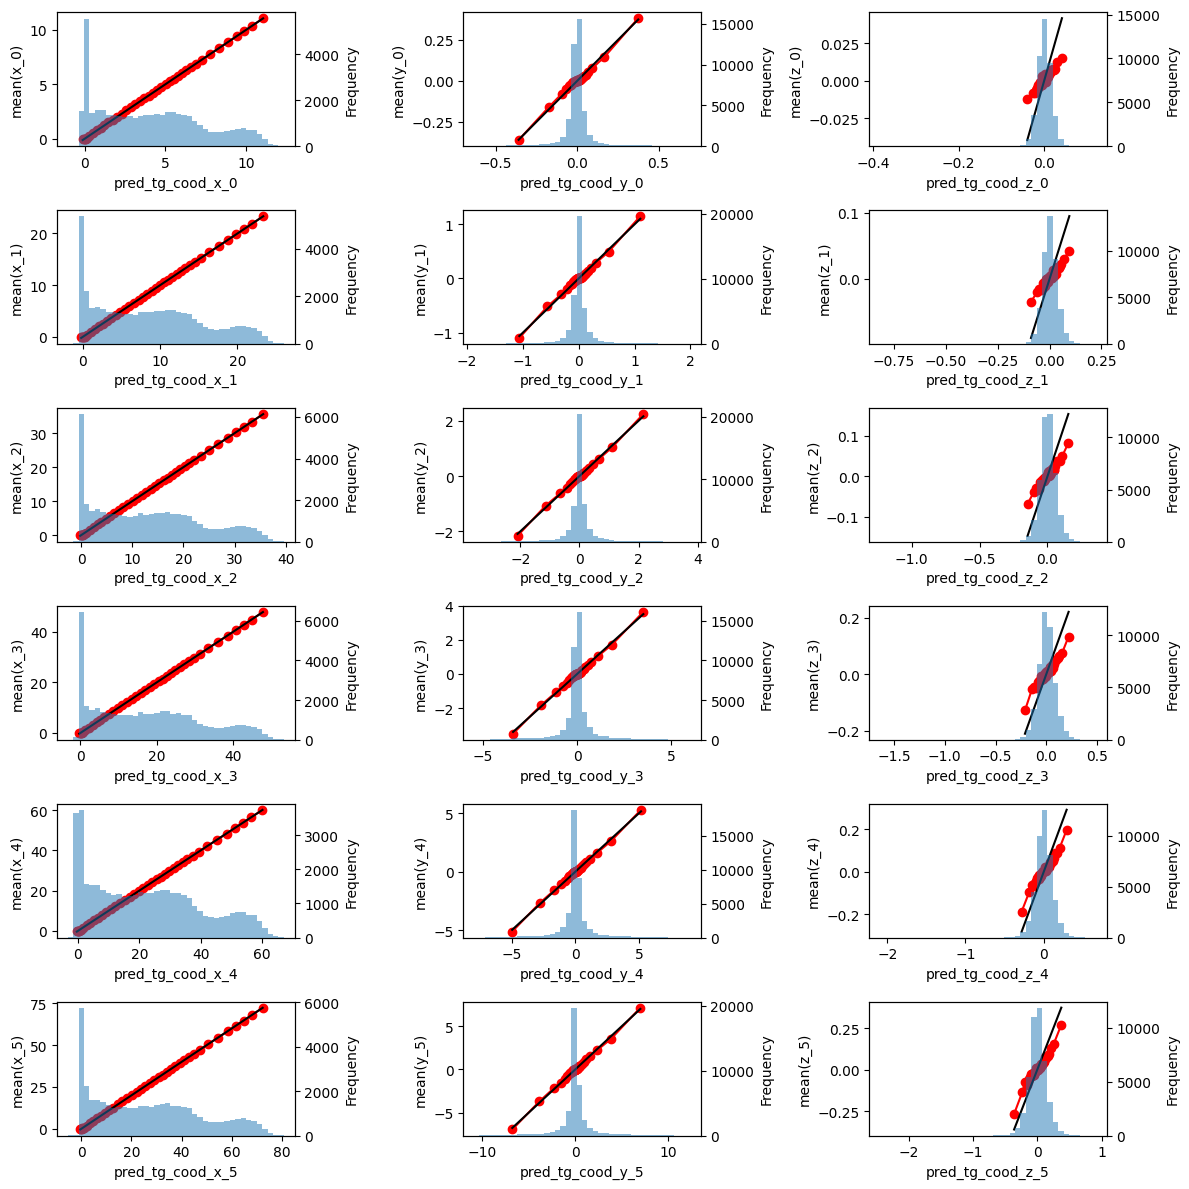

In [15]:
utils.plot_calibration_curve(tr_df, pred_cols, n_bins=40)

## Submission

In [16]:
preds = utils.predict(models, ts_images, ts_df, feature.columns, pred_cols)
preds

pred_tg_cood_x_0,pred_tg_cood_y_0,pred_tg_cood_z_0,pred_tg_cood_x_1,pred_tg_cood_y_1,pred_tg_cood_z_1,pred_tg_cood_x_2,pred_tg_cood_y_2,pred_tg_cood_z_2,pred_tg_cood_x_3,pred_tg_cood_y_3,pred_tg_cood_z_3,pred_tg_cood_x_4,pred_tg_cood_y_4,pred_tg_cood_z_4,pred_tg_cood_x_5,pred_tg_cood_y_5,pred_tg_cood_z_5
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1.509758,-0.018221,-0.005054,3.044772,-0.019531,-0.001742,4.738007,-0.045454,-0.001684,6.069377,-0.051581,0.007502,7.457631,-0.049534,0.007751,9.088376,0.005391,0.014333
0.932048,0.349524,-0.012884,1.818762,0.980057,-0.030041,2.578672,1.839686,-0.047981,3.079198,2.903566,-0.066116,3.560373,4.205268,-0.064349,4.087225,5.741265,-0.068266
1.598028,-0.001207,-0.011351,3.171161,-0.001873,-0.02644,4.57943,-0.047173,-0.033215,5.96015,-0.077133,-0.044522,6.946936,-0.154659,-0.053993,8.64803,-0.205529,-0.070896
0.871958,0.011195,-0.030217,1.66463,0.102591,-0.054127,2.505206,0.290307,-0.087247,3.150758,0.587244,-0.118582,3.773296,1.098332,-0.148441,4.441225,1.827261,-0.174121
0.837064,0.005958,-0.019604,1.453228,0.009477,-0.044207,1.825304,0.015227,-0.071581,2.164904,0.041682,-0.09515,2.304175,0.051541,-0.119569,2.382301,0.055739,-0.145934
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6.511713,0.031,0.011041,13.759758,0.12469,0.026059,20.915606,0.325359,0.034439,28.063427,0.594211,0.027763,35.284931,1.001127,0.020828,42.494003,1.471195,0.000783
7.011106,-0.023061,-0.021758,14.871643,-0.064813,-0.052736,22.760979,-0.104426,-0.101066,30.936796,-0.140111,-0.173117,38.823196,-0.170514,-0.235212,46.902672,-0.185818,-0.320655
7.479311,-0.023991,0.006354,15.798719,-0.068153,0.012029,24.071224,-0.114191,0.029264,32.38868,-0.168723,0.055721,40.605572,-0.213992,0.080571,48.913074,-0.233573,0.115328


In [17]:
def create_submission_csv(preds: pl.DataFrame, filename: str = "submission.csv"):
    submission_cols = sum([[f"x_{i}", f"y_{i}", f"z_{i}"] for i in range(6)], [])

    # validate preds columns
    if len(preds.columns) != len(submission_cols):
        raise ValueError(
            f"preds columns must be {len(submission_cols)}, but got {len(preds.columns)}"
        )

    preds.columns = submission_cols
    preds.write_csv(filename)
    print(f"Submission file is created: {filename}")


create_submission_csv(preds)

Submission file is created: submission.csv
